In [1]:
%load_ext autoreload
%autoreload 2

import os
import yaml

import torch
torch.manual_seed(0)

import numpy as np
np.random.seed(0)

from utils.parsing import load_train_args
import datasets.single_mol_dataset as single_mol_dataset
from utils.model import construct_model

model_dir = '/data/rsg/nlp/sdobers/michael/gen/workdir/best'
ckpt = 'model_4250.ckpt'

args = load_train_args(os.path.join(model_dir, 'args.yaml'))
args.__dict__["batch_size"] = 4096
args.__dict__["wandb"] = False

args.__dict__["num_frames"] = 10_000_000
args.__dict__["max_number_of_frames"] = 10_000_000
args.__dict__["data_save_frequency"] = 1


#args.__dict__["torch_device"] = 'cpu'
#args.__dict__["md_device"] = 'CPU'

print(f"Loaded training args from run {args.run_name}")

dataset = single_mol_dataset.SingleMolDataset(args)

Warning on use of the timeseries module: If the inherent timescales of the system are long compared to those being analyzed, this statistical inefficiency may be an underestimate.  The estimate presumes the use of many statistically independent samples.  Tests should be performed to assess whether this condition is satisfied.   Be cautious in the interpretation of the data.


Loaded training args from run ALDP_RKL0_KL1_h256_u12_warmup_lrcosine_rerun


/data/rsg/nlp/mplainer/miniconda3/envs/gen/lib/python3.11/site-packages/boltzgen-0.1-py3.11.egg/boltzgen/distributions.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/data/rsg/nlp/mplainer/miniconda3/envs/gen/lib/python3.11/site-packages/boltzgen-0.1-py3.11.egg/boltzgen/distributions.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
2023-11-25 02:31:02,849 [rosetta13.csail.mit.edu:3974525] [INFO] Loading data from data/flow_datasets/AlanineDipeptideImplicit_md_data_temp300_saveFreq1_numFrame10000000.npy
2023-11-25 02:31:06,571 [rosetta13.csail.mit.edu:3974525] [INFO] Loaded 10000000 frames


In [2]:
import matplotlib.pyplot as plt
import os

# You can comment this out if you don't want to load the style used for the paper
plt.style.use(['plot_style.txt'])

In [3]:
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from tps.states import ALDP_STATES
import copy

ALDP_STATES_NAMED = copy.deepcopy(ALDP_STATES)
ALDP_STATES_NAMED[0].name = r'$C_5$'
ALDP_STATES_NAMED[1].name = r'$P_{II}$'
ALDP_STATES_NAMED[2].name = r'$\alpha_P$'
ALDP_STATES_NAMED[3].name = r'$\alpha_R$'
ALDP_STATES_NAMED[4].name = r'$C_7$'
ALDP_STATES_NAMED[5].name = r'$\alpha_L$'

def ramachandran_paper(phi, psi, states=None, bins=100, alpha=0.6, hist=True, path=None, no_ticks=False):
    if hist:
        plt.hist2d(phi, psi, bins=bins, norm = colors.LogNorm(), rasterized=True)
    plt.xlim(-np.pi, np.pi)
    plt.ylim(-np.pi, np.pi)
    
    plt.gca().set_xticks([])
    plt.gca().set_yticks([])
    
    if not no_ticks:
        plt.gca().set_xticks([-np.pi, -np.pi / 2, 0, np.pi / 2, np.pi])
        plt.gca().set_xticklabels([r'$-\pi$', r'$-\frac {\pi} {2}$', '0', r'$\frac {\pi} {2}$', r'$\pi$'])

        plt.gca().set_yticks([-np.pi, -np.pi / 2, 0, np.pi / 2, np.pi])
        plt.gca().set_yticklabels([r'$-\pi$', r'$-\frac {\pi} {2}$', '0', r'$\frac {\pi} {2}$', r'$\pi$'])

        plt.xlabel(r'$\phi$')
        plt.ylabel(r'$\psi$')
    plt.gca().set_aspect('equal', adjustable='box')
    
    if path is not None:
        dist = np.sqrt(np.sum(np.diff(path, axis=0)**2, axis=1))
        mask = np.hstack([ dist > np.pi, [False]])
        masked_path_x, masked_path_y  = np.ma.MaskedArray(path[:, 0], mask), np.ma.MaskedArray(path[:, 1], mask)
        masked_path_x, masked_path_y
        plt.plot(masked_path_x, masked_path_y, color="red")
    
    for state in (states if states is not None else []):
        c = plt.Circle(state.center, radius=state.radius(), edgecolor='gray', alpha=alpha, facecolor='white', ls='--', lw=0.7)
        plt.gca().add_patch(c)
        plt.gca().annotate(state.name, xy=state.center, fontsize=6, ha="center", va="center")


In [12]:
from tps.states import ALDP_STATES
from utils.plotting import ramachandran_plot
from tps.sampling import PathSetup
start_state_idx, end_state_idx = 0, 3
path_setup = PathSetup(ALDP_STATES[start_state_idx], ALDP_STATES[end_state_idx])

In [13]:
#paths_md_full_exclusive = dataset.transition_paths_phis_psis(path_setup, ALDP_STATES, shortest_paths_only=False)
#paths_md_full = dataset.transition_paths_phis_psis(path_setup, [], shortest_paths_only=False)
#paths_md_full_shortest_exlusive = dataset.transition_paths_phis_psis(path_setup, ALDP_STATES, shortest_paths_only=True)
paths_md_full_shortest = dataset.transition_paths_phis_psis(path_setup, [], shortest_paths_only=True)


 99%|███████████████████████████████████████████████████████████████████████████████████████████▎| 2077331/2091755 [00:00<00:00, 2568631.62it/s]
2023-11-25 02:38:29,973 [rosetta13.csail.mit.edu:3974525] [INFO] Found 222 transition paths


In [14]:
ramachandran_plot(paths_md_full_shortest[:, 0], paths_md_full_shortest[:, 1], ALDP_STATES, title='Shortest Paths, all Transitions')

In [15]:
from tqdm import tqdm

paths_full_idx = dataset.transition_paths(path_setup, [], shortest_paths_only=True)
paths_full = [dataset.frames[start:stop] for start, stop in paths_full_idx]
paths = [np.array(dataset.phis_psis(p)).T for p in tqdm(paths_full)]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 222/222 [00:00<00:00, 2109.64it/s]


In [24]:
np.argmin(np.array([stop - start for start, stop in paths_full_idx]))

96

6558406

In [72]:
start, stop = np.array([(start, stop) for start, stop in paths_full_idx])[1]
start -= 3000
stop -= 300

In [98]:
stride = 15
paths_animation_full = dataset.frames[start:stop:stride]
paths_animation = np.array(dataset.phis_psis(paths_animation_full)).T

len(paths_animation)

468

In [99]:
from datasets.single_mol_dataset import save_pdb_transition
from boltzgen import CoordinateTransform
from model.internal_flow import ind_circ_dih, z_matrix, cart_indices, default_std

dim = dataset.reference_frame.shape[0] * 3
coordinate_transform = CoordinateTransform(torch.from_numpy(dataset.reference_frame).view(-1, dim), dim,
                                                z_matrix, cart_indices, mode='internal',
                                                ind_circ_dih=ind_circ_dih, shift_dih=False,
                                                default_std=default_std)

# To align the original structure, we put it into internal coordinates and then back
aligned = coordinate_transform.forward(coordinate_transform.inverse(paths_animation_full.view(-1, 66))[0])[0]

save_pdb_transition('./data/aldp.pdb', 'animation/animation.pdb', aligned.view(-1, 22, 3).cpu().detach().numpy())

  6%|██████                                                                                                    | 27/468 [00:27<13:46,  1.87s/it]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 165.95it/s]


 18%|██████████████████▌                                                                                       | 82/468 [03:32<30:24,  4.73s/it]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 147.87it/s]


 29%|██████████████████████████████▋                                                                          | 137/468 [09:28<44:46,  8.12s/it]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 64.57it/s]


 44%|█████████████████████████████████████████████▊                                                           | 204/468 [20:35<51:16, 11.65s/it]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 53.36it/s]


 57%|███████████████████████████████████████████████████████████▉                                             | 267/468 [35:09<51:19, 15.32s/it]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 53.86it/s]


 69%|████████████████████████████████████████████████████████████████████████▏                                | 322/468 [51:04<45:37, 18.75s/it]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.48it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████▉                    | 377/468 [1:09:45<32:59, 21.75s/it]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.07it/s]


 92%|███████████████████████████████████████████████████████████████████████████████████████████████        | 432/468 [1:31:40<15:10, 25.29s/it]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 33.24it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [1:47:31<00:00, 13.78s/it]


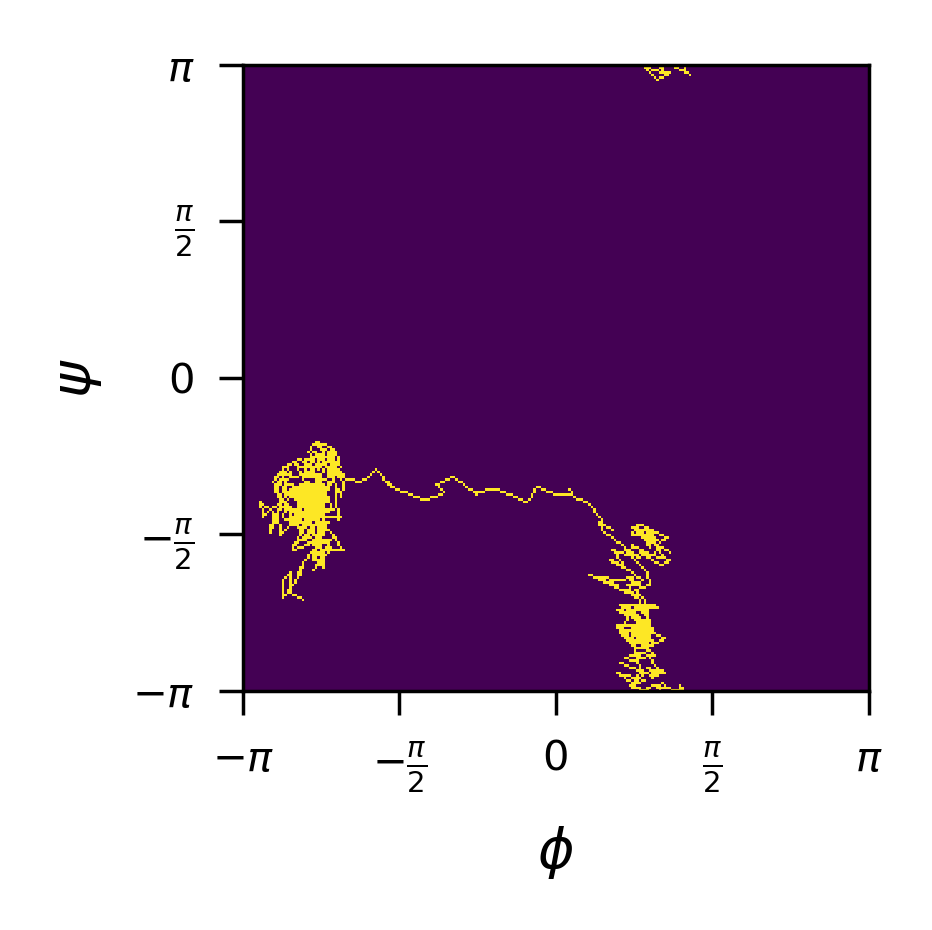

In [101]:
from tqdm import trange
from tps.plot import PeriodicPathHistogram
import matplotlib.pyplot as plt
import matplotlib.colors as colors

for i in trange(len(paths_animation)):
    path_hist = PeriodicPathHistogram()
    path_hist.add_paths([paths_animation[:i+1]])
    path_hist.plot( rasterized=True)
    ramachandran_paper(None, None, [], bins=150, alpha=1, hist=False)
    plt.savefig(f'animation/{i:03d}.png', bbox_inches='tight')

In [132]:
from tps.mcmc.density import LangevinDensityEstimator
from openmm import unit

density = LangevinDensityEstimator(dataset, independent_steps=False, step_size=args.data_save_frequency * unit.femtosecond)
paths_density = [density(p) for p in tqdm(paths_full)]

 25%|████████████████████████████                                                                                    | 1/4 [00:00<00:00,  7.84it/s]

KeyboardInterrupt: 

In [ ]:
paths_density = np.array(paths_density)

In [109]:
np.median(paths_density)

-165831.60891079

In [122]:
np.array([p for p in paths_density > np.percentile(paths_density, 50)]).mean()

0.5

(-565831.60891079, 0.0)

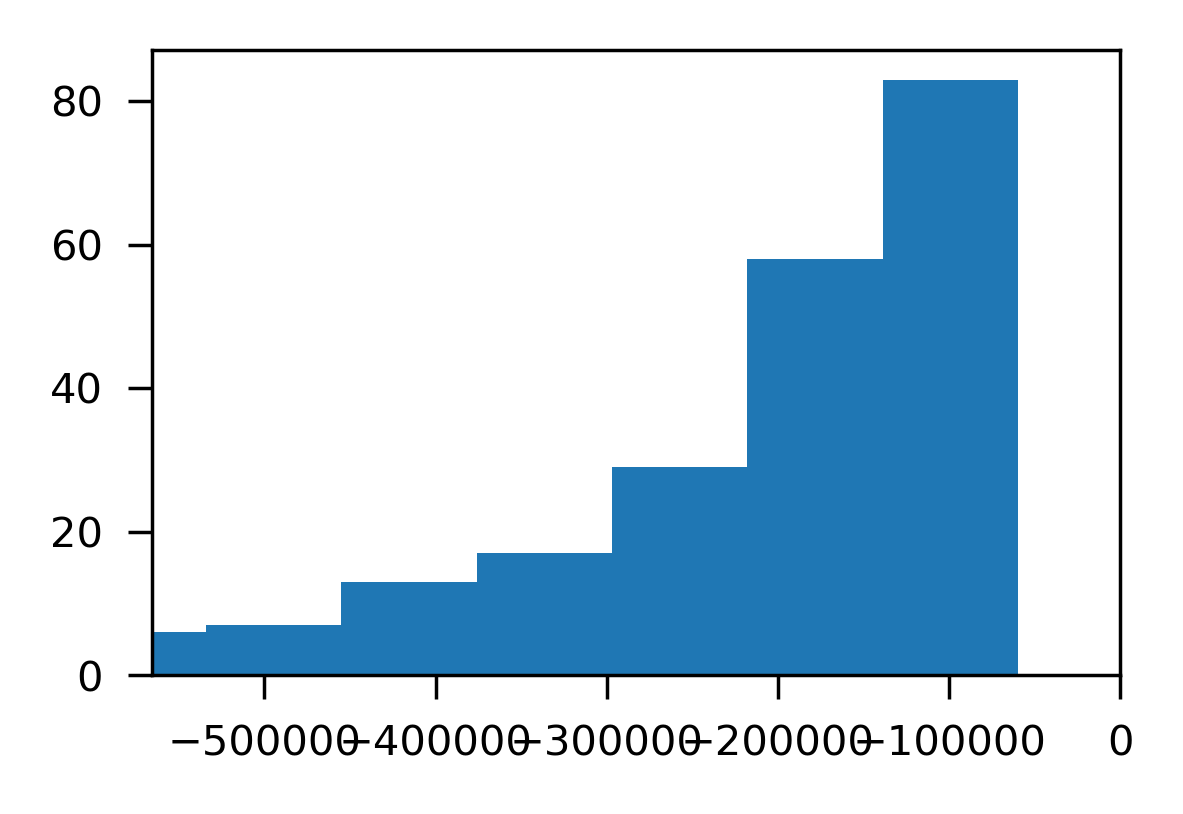

In [112]:
plt.hist(paths_density, bins=30)
plt.xlim(-565831.60891079, 0)

In [143]:
[p for i, p in enumerate(paths) if paths_density[i] > np.percentile(paths_density, )]

TypeError: percentile() missing 1 required positional argument: 'q'


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 97.38it/s]


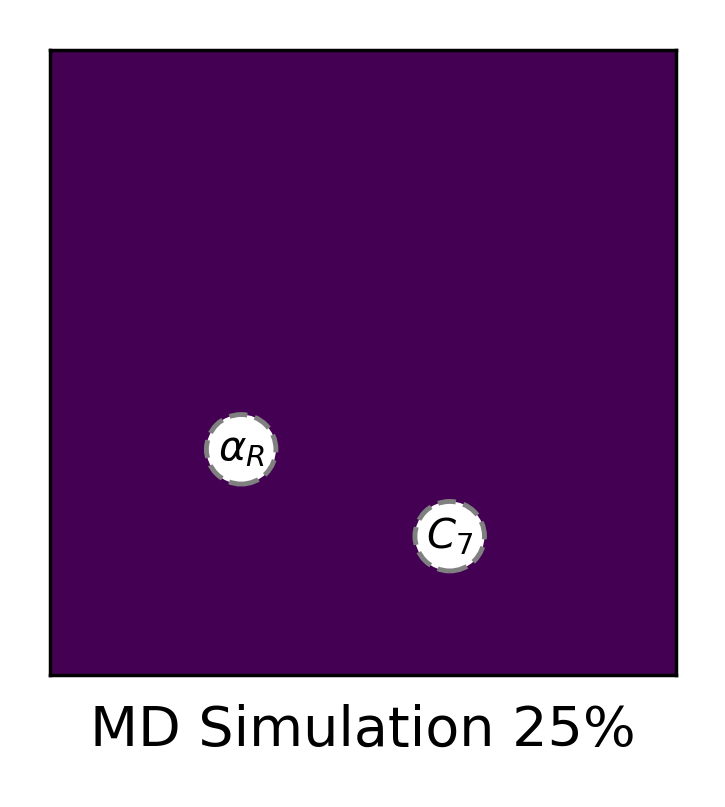

In [144]:
from tps.plot import PeriodicPathHistogram
import matplotlib.pyplot as plt
import matplotlib.colors as colors

path_hist = PeriodicPathHistogram()
#path_hist.add_paths([p for i, p in enumerate(paths) if paths_density[i] > np.percentile(paths_density, 75)])
path_hist.add_paths([p for i, p in enumerate(paths) if len(p) <= min([len(p) for p in paths])]) # we only have 4 paths, so we take the shortest one

#plt.title('Shortest Paths, all Transitions')
path_hist.plot(norm=colors.LogNorm(), rasterized=True)
#path_hist.plot(norm=colors.LogNorm(), rasterized=True)
ramachandran_paper(None, None, [ALDP_STATES_NAMED[start_state_idx], ALDP_STATES_NAMED[end_state_idx]], bins=150, alpha=1, hist=False)
plt.xlabel('MD Simulation 25%')
plt.ylabel('')
plt.savefig('figures/ramachandran-aldp-ground-truth-top25.pdf', bbox_inches='tight')

In [147]:
single_path = [p for i, p in enumerate(paths) if len(p) <= min([len(p) for p in paths])][0]

array([[ 0.59273803, -1.5395924 ],
       [ 0.5922669 , -1.5363772 ],
       [ 0.58833706, -1.5308464 ],
       [ 0.5813245 , -1.5228994 ],
       [ 0.57192874, -1.5130053 ],
       [ 0.5601044 , -1.5009732 ],
       [ 0.5459638 , -1.4868375 ],
       [ 0.5301072 , -1.4711387 ],
       [ 0.51342136, -1.4543947 ],
       [ 0.49620587, -1.4368862 ],
       [ 0.47930232, -1.4191327 ],
       [ 0.46328652, -1.4017357 ],
       [ 0.4483052 , -1.3850522 ],
       [ 0.43486267, -1.369708  ],
       [ 0.4230463 , -1.3557346 ],
       [ 0.41323915, -1.3434094 ],
       [ 0.40547648, -1.3330393 ],
       [ 0.39926186, -1.3242865 ],
       [ 0.39450142, -1.3172029 ],
       [ 0.39033362, -1.3114104 ],
       [ 0.38627952, -1.3063343 ],
       [ 0.38183808, -1.3016346 ],
       [ 0.37632933, -1.2970561 ],
       [ 0.36981186, -1.292289  ],
       [ 0.36231655, -1.2871224 ],
       [ 0.353569  , -1.2816621 ],
       [ 0.34301707, -1.2755227 ],
       [ 0.3312852 , -1.2685715 ],
       [ 0.31915593,

In [2]:
from tps.plot import PeriodicPathHistogram
import matplotlib.pyplot as plt
import matplotlib.colors as colors

path_hist = PeriodicPathHistogram()
#path_hist.add_paths([p for i, p in enumerate(paths) if paths_density[i] > np.percentile(paths_density, 75)])
path_hist.add_paths([p for i, p in enumerate(paths) if len(p) <= min([len(p) for p in paths])]) # we only have 4 paths, so we take the shortest one

#plt.title('Shortest Paths, all Transitions')
path_hist.plot(rasterized=True, cmin=0.1)
#path_hist.plot(norm=colors.LogNorm(), rasterized=True)
ramachandran_paper(None, None, [ALDP_STATES_NAMED[start_state_idx], ALDP_STATES_NAMED[end_state_idx]], bins=150, alpha=1, hist=False)
plt.xlabel('MD Simulation 25%')
plt.ylabel('')
plt.savefig('figures/ramachandran-aldp-ground-truth-top25-hard-modes.pdf', bbox_inches='tight')

NameError: name 'paths' is not defined

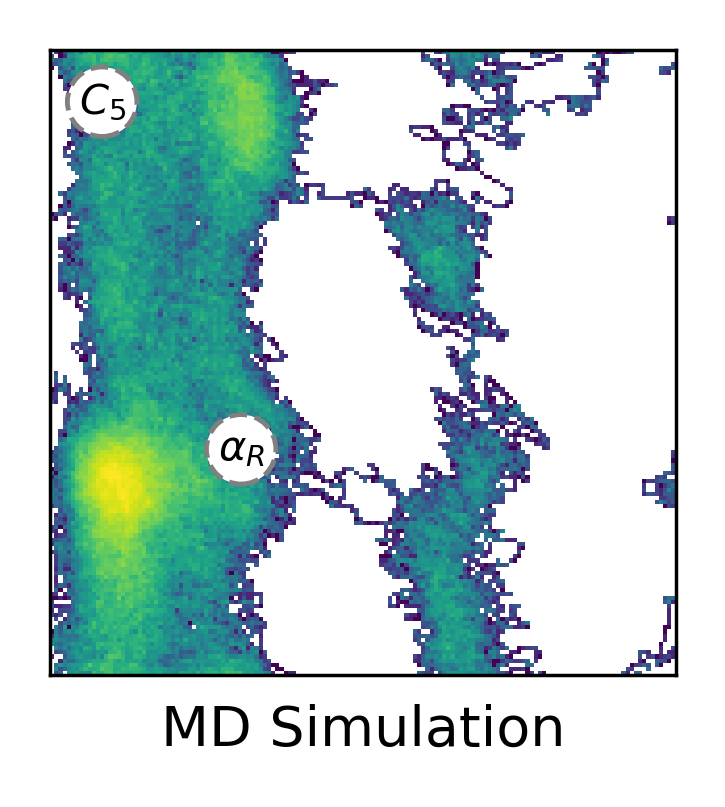

In [56]:
paths_filtered = [p for p in paths]
paths_filtered = np.concatenate(paths_filtered)

plt.xlabel('MD Simulation')
ramachandran_paper(paths_filtered[:, 0], paths_filtered[:, 1], [ALDP_STATES_NAMED[start_state_idx], ALDP_STATES_NAMED[end_state_idx]], bins=150, alpha=1)
plt.savefig('figures/ramachandran-aldp-ground-truth-hist.pdf', bbox_inches='tight')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 455.60it/s]


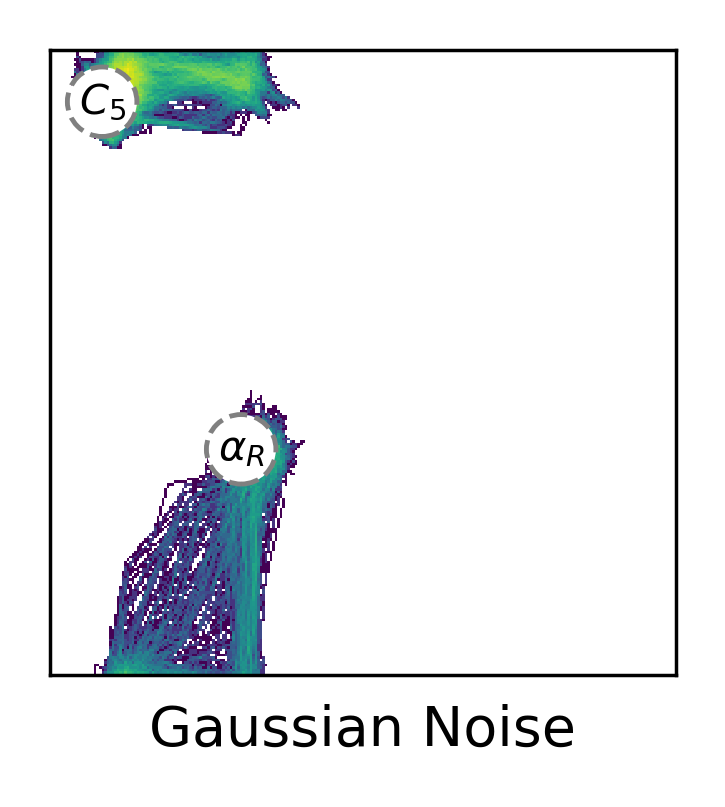

/data/rsg/nlp/mplainer/gen/tps/evaluation/utils.py:72: RuntimeWarning:

divide by zero encountered in log

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 492.72it/s]
/tmp/ipykernel_367089/3473181632.py:20: RuntimeWarning:

divide by zero encountered in log

/tmp/ipykernel_367089/3473181632.py:20: RuntimeWarning:

invalid value encountered in subtract

/tmp/ipykernel_367089/3473181632.py:20: RuntimeWarning:

invalid value encountered in multiply



Gaussian Noise  {'KL-NN': '3.26e+00', 'KL-PathHist': '2.48e-03', 'PathHist-AbsDist': '2.21e-05'}


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 3147.72it/s]


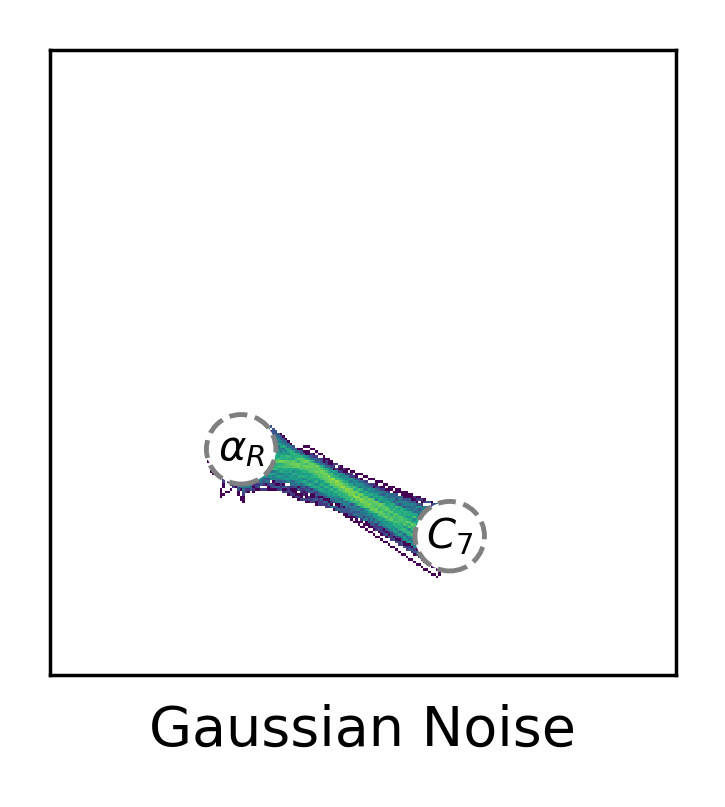

/data/rsg/nlp/mplainer/gen/tps/evaluation/utils.py:72: RuntimeWarning:

divide by zero encountered in log

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 3211.95it/s]
/tmp/ipykernel_367089/3473181632.py:20: RuntimeWarning:

divide by zero encountered in log

/tmp/ipykernel_367089/3473181632.py:20: RuntimeWarning:

invalid value encountered in subtract

/tmp/ipykernel_367089/3473181632.py:20: RuntimeWarning:

invalid value encountered in multiply



Gaussian Noise hard {'KL-NN': '5.27e+00', 'KL-PathHist': '-2.92e-03', 'PathHist-AbsDist': '2.71e-05'}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 475.41it/s]


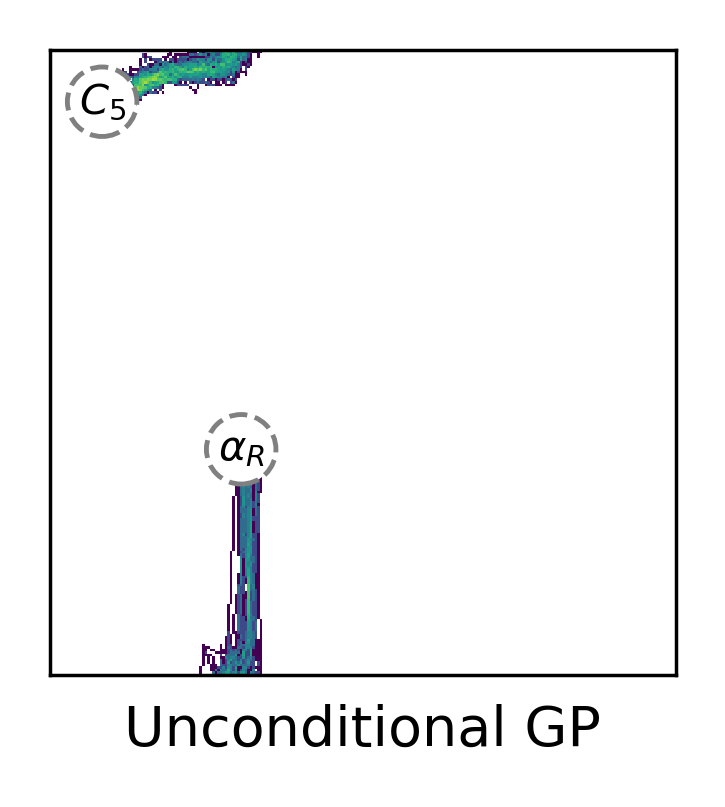

/data/rsg/nlp/mplainer/gen/tps/evaluation/utils.py:72: RuntimeWarning:

divide by zero encountered in log

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 414.02it/s]
/tmp/ipykernel_367089/3473181632.py:20: RuntimeWarning:

divide by zero encountered in log

/tmp/ipykernel_367089/3473181632.py:20: RuntimeWarning:

invalid value encountered in subtract

/tmp/ipykernel_367089/3473181632.py:20: RuntimeWarning:

invalid value encountered in multiply



Unconditional GP  {'KL-NN': '4.33e+00', 'KL-PathHist': '-2.73e-03', 'PathHist-AbsDist': '2.93e-05'}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 720.26it/s]


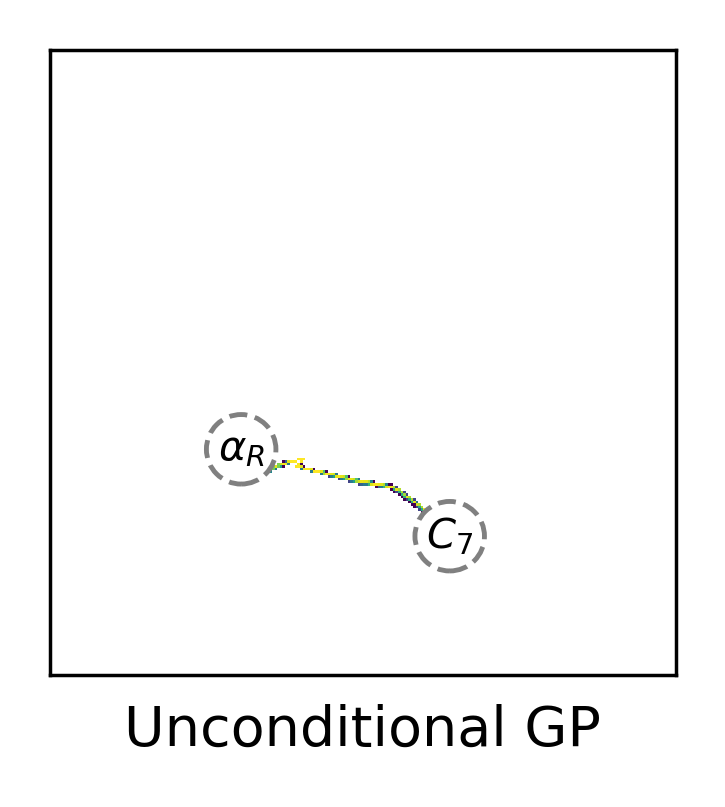

/data/rsg/nlp/mplainer/gen/tps/evaluation/utils.py:72: RuntimeWarning:

divide by zero encountered in log

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 673.49it/s]
/tmp/ipykernel_367089/3473181632.py:20: RuntimeWarning:

divide by zero encountered in log

/tmp/ipykernel_367089/3473181632.py:20: RuntimeWarning:

invalid value encountered in subtract

/tmp/ipykernel_367089/3473181632.py:20: RuntimeWarning:

invalid value encountered in multiply



Unconditional GP hard {'KL-NN': '6.10e+00', 'KL-PathHist': '-1.08e-03', 'PathHist-AbsDist': '3.15e-05'}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 525.30it/s]


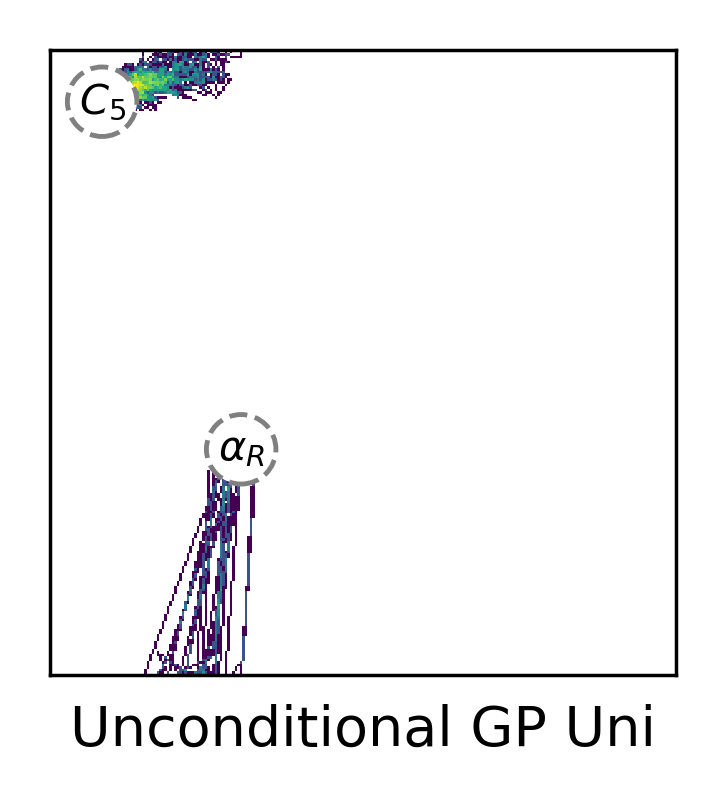

/data/rsg/nlp/mplainer/gen/tps/evaluation/utils.py:72: RuntimeWarning:

divide by zero encountered in log

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 504.88it/s]
/tmp/ipykernel_367089/3473181632.py:20: RuntimeWarning:

divide by zero encountered in log

/tmp/ipykernel_367089/3473181632.py:20: RuntimeWarning:

invalid value encountered in subtract

/tmp/ipykernel_367089/3473181632.py:20: RuntimeWarning:

invalid value encountered in multiply



Unconditional GP Uni  {'KL-NN': '3.85e+00', 'KL-PathHist': '-3.83e-03', 'PathHist-AbsDist': '2.89e-05'}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 645.49it/s]


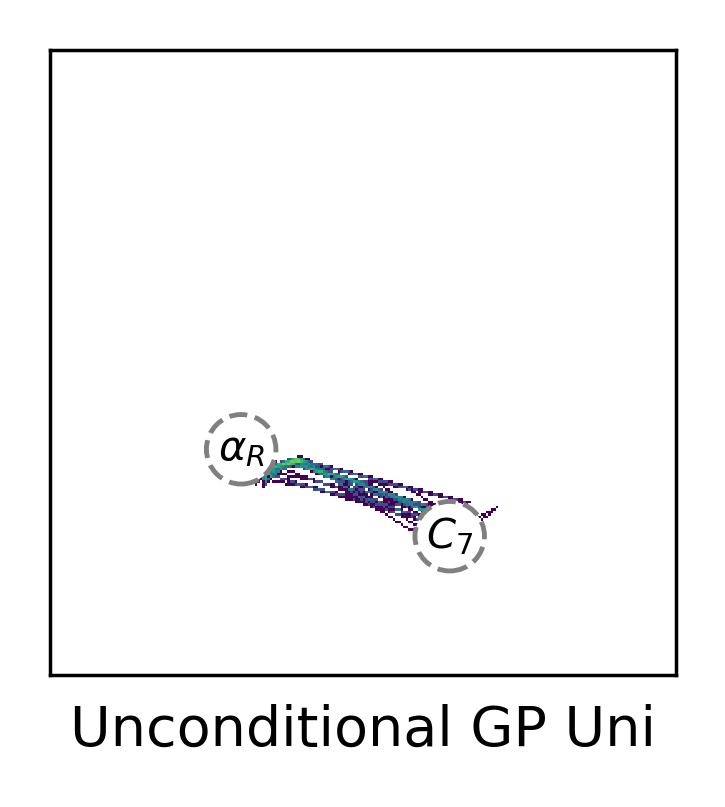

/data/rsg/nlp/mplainer/gen/tps/evaluation/utils.py:72: RuntimeWarning:

divide by zero encountered in log

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 667.40it/s]
/tmp/ipykernel_367089/3473181632.py:20: RuntimeWarning:

divide by zero encountered in log

/tmp/ipykernel_367089/3473181632.py:20: RuntimeWarning:

invalid value encountered in subtract

/tmp/ipykernel_367089/3473181632.py:20: RuntimeWarning:

invalid value encountered in multiply



Unconditional GP Uni hard {'KL-NN': '5.13e+00', 'KL-PathHist': '-2.88e-03', 'PathHist-AbsDist': '2.96e-05'}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 333.52it/s]


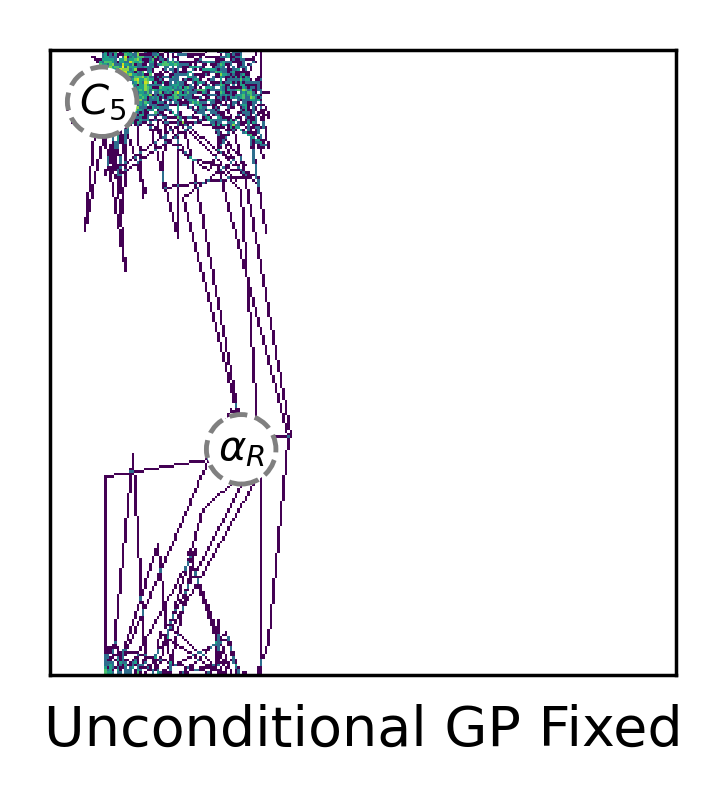

/data/rsg/nlp/mplainer/gen/tps/evaluation/utils.py:72: RuntimeWarning:

divide by zero encountered in log

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 329.74it/s]
/tmp/ipykernel_367089/3473181632.py:20: RuntimeWarning:

divide by zero encountered in log

/tmp/ipykernel_367089/3473181632.py:20: RuntimeWarning:

invalid value encountered in subtract

/tmp/ipykernel_367089/3473181632.py:20: RuntimeWarning:

invalid value encountered in multiply



Unconditional GP Fixed  {'KL-NN': '1.68e+00', 'KL-PathHist': '-5.34e-03', 'PathHist-AbsDist': '2.51e-05'}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 266.23it/s]


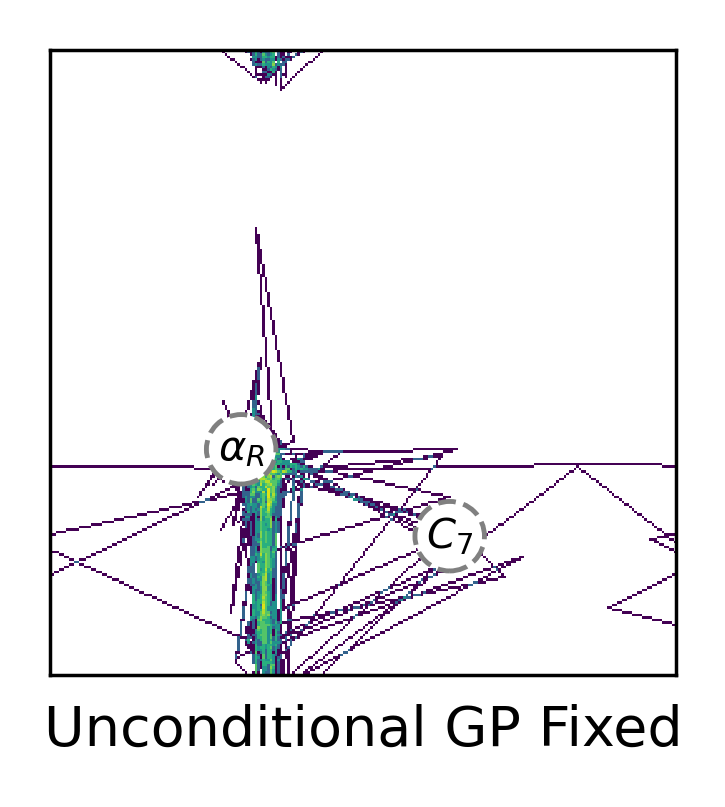

/data/rsg/nlp/mplainer/gen/tps/evaluation/utils.py:72: RuntimeWarning:

divide by zero encountered in log

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 343.51it/s]
/tmp/ipykernel_367089/3473181632.py:20: RuntimeWarning:

divide by zero encountered in log

/tmp/ipykernel_367089/3473181632.py:20: RuntimeWarning:

invalid value encountered in subtract

/tmp/ipykernel_367089/3473181632.py:20: RuntimeWarning:

invalid value encountered in multiply



Unconditional GP Fixed hard {'KL-NN': '3.06e+00', 'KL-PathHist': '-2.48e-03', 'PathHist-AbsDist': '2.62e-05'}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 453.64it/s]


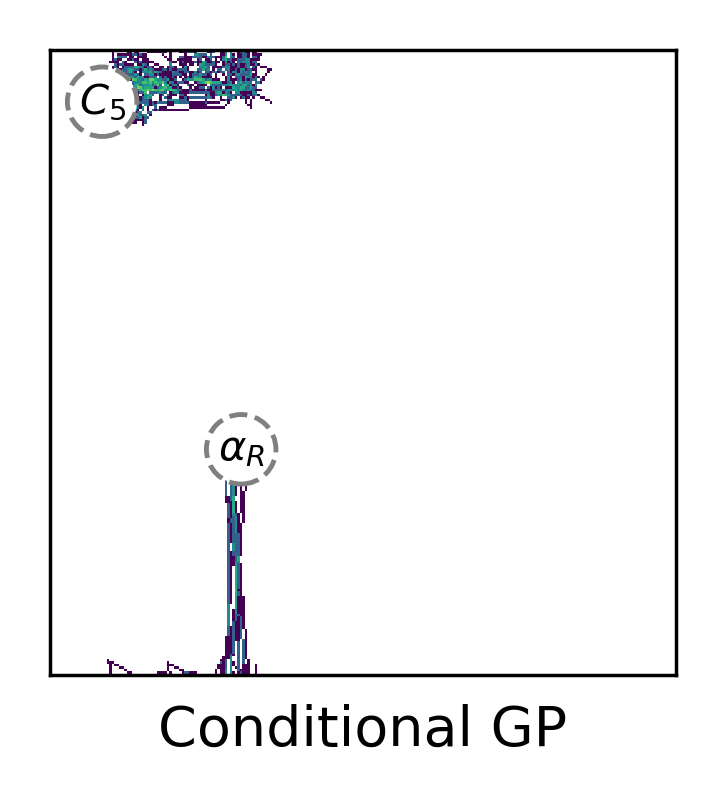

/data/rsg/nlp/mplainer/gen/tps/evaluation/utils.py:72: RuntimeWarning:

divide by zero encountered in log

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 502.56it/s]
/tmp/ipykernel_367089/3473181632.py:20: RuntimeWarning:

divide by zero encountered in log

/tmp/ipykernel_367089/3473181632.py:20: RuntimeWarning:

invalid value encountered in subtract

/tmp/ipykernel_367089/3473181632.py:20: RuntimeWarning:

invalid value encountered in multiply



Conditional GP  {'KL-NN': '3.19e+00', 'KL-PathHist': '-4.02e-03', 'PathHist-AbsDist': '2.89e-05'}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 728.50it/s]


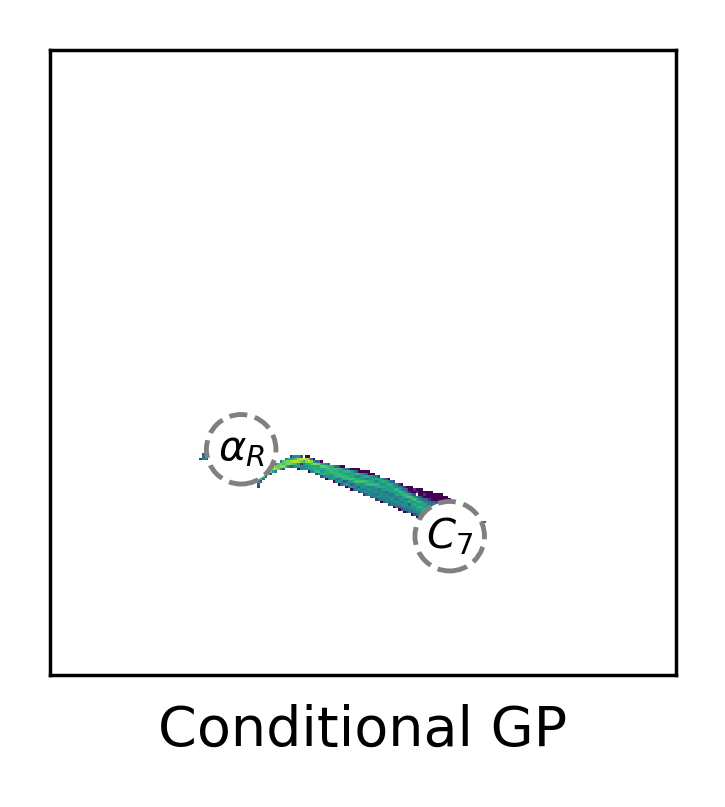

/data/rsg/nlp/mplainer/gen/tps/evaluation/utils.py:72: RuntimeWarning:

divide by zero encountered in log

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 712.81it/s]
/tmp/ipykernel_367089/3473181632.py:20: RuntimeWarning:

divide by zero encountered in log

/tmp/ipykernel_367089/3473181632.py:20: RuntimeWarning:

invalid value encountered in subtract

/tmp/ipykernel_367089/3473181632.py:20: RuntimeWarning:

invalid value encountered in multiply



Conditional GP hard {'KL-NN': '6.80e+00', 'KL-PathHist': '-2.22e-03', 'PathHist-AbsDist': '3.04e-05'}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 325/325 [00:00<00:00, 525.04it/s]


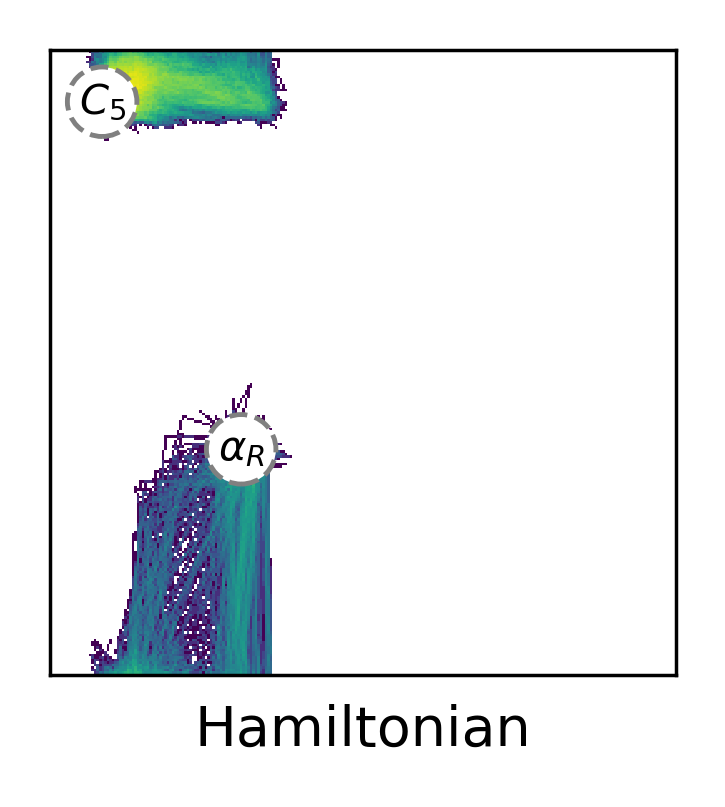

/data/rsg/nlp/mplainer/gen/tps/evaluation/utils.py:72: RuntimeWarning:

divide by zero encountered in log

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 325/325 [00:00<00:00, 498.05it/s]
/tmp/ipykernel_367089/3473181632.py:20: RuntimeWarning:

divide by zero encountered in log

/tmp/ipykernel_367089/3473181632.py:20: RuntimeWarning:

invalid value encountered in subtract

/tmp/ipykernel_367089/3473181632.py:20: RuntimeWarning:

invalid value encountered in multiply



Hamiltonian  {'KL-NN': '3.58e+00', 'KL-PathHist': '5.75e-03', 'PathHist-AbsDist': '2.35e-05'}


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 3354.38it/s]


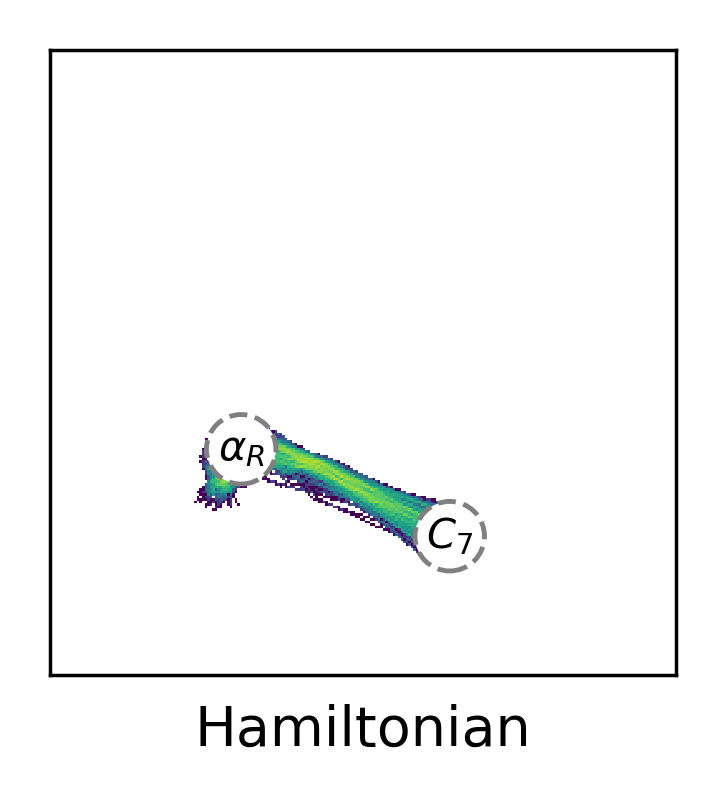

/data/rsg/nlp/mplainer/gen/tps/evaluation/utils.py:72: RuntimeWarning:

divide by zero encountered in log

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 3045.85it/s]

Hamiltonian hard {'KL-NN': '4.89e+00', 'KL-PathHist': '-2.56e-03', 'PathHist-AbsDist': '2.67e-05'}



/tmp/ipykernel_367089/3473181632.py:20: RuntimeWarning:

divide by zero encountered in log

/tmp/ipykernel_367089/3473181632.py:20: RuntimeWarning:

invalid value encountered in subtract

/tmp/ipykernel_367089/3473181632.py:20: RuntimeWarning:

invalid value encountered in multiply



<Figure size 1250x812.5 with 0 Axes>

In [119]:
import pickle
from tps.plot import PeriodicPathHistogram
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from tps.evaluation.utils import kl_divergence2d
def distances(ground_truth, other):
    kl_nn = kl_divergence2d(ground_truth.reshape(-1, 2), other.reshape(-1, 2))
    
    path_hist_ground_truth = PeriodicPathHistogram()
    path_hist_ground_truth.add_paths(ground_truth)
    path_hist_other = PeriodicPathHistogram()
    path_hist_other.add_paths(other)
    H_ground_truth = path_hist_ground_truth.hist
    H_other = path_hist_other.hist
    
    dist = 2 * path_hist_ground_truth.scale / path_hist_ground_truth.bins
        
    Hp = H_ground_truth / H_ground_truth.sum()
    Hq = H_other / H_other.sum()
    kl_pathhist_2d = Hp * (np.log(Hp) - np.log(Hq)) * dist
    kl_pathhist_2d = np.sum(kl_pathhist_2d[np.isfinite(kl_pathhist_2d)])
    
    abs_hist_dist = np.mean(np.abs(Hp - Hq))
    
    def format_num(original_float):
        return np.format_float_scientific(original_float, precision=2, exp_digits=2)
    
    return {'KL-NN': format_num(kl_nn), 'KL-PathHist': format_num(kl_pathhist_2d), 'PathHist-AbsDist': format_num(abs_hist_dist)}

figures = [
    ('Gaussian Noise', 'latent-noise', 'mcmc_prob_langevin_40_noise0.1'),
    ('Gaussian Noise', 'latent-noise-hard-modes', '34mcmc_prob_langevin_40_noise0.05'),
    ('Unconditional GP', 'gp', 'mcmc_40_langevin_fastgp15_gaussian0_alpha1e-2'),
    ('Unconditional GP', 'gp-hard-modes', '34mcmc_40_langevin_fastgp15_gaussian0_alpha1e-2'),
    ('Unconditional GP Uni', 'gp-uniform', 'mcmc_40_langevin_fastgp15_uniform_alpha1e-2'),
    ('Unconditional GP Uni', 'gp-uniform-hard-modes', '34mcmc_40_langevin_fastgp15_uniform_alpha1e-2'),
    ('Unconditional GP Fixed', 'gp-fixed', 'mcmc_40_langevin_fastgpfixed_gaussian0_alpha1e-2'),
    ('Unconditional GP Fixed', 'gp-fixed-hard-modes', '34mcmc_40_langevin_fastgpfixed_gaussian0_alpha1e-2'),
    ('Conditional GP', 'conditional-gp', 'mcmc_40_langevin_fastgp15_gaussian0_alpha1e-2_conditioned'),
    ('Conditional GP', 'conditional-gp-hard-modes', '34mcmc_40_langevin_fastgp15_gaussian0_alpha1e-2_conditioned'),
    #('Conditional GP Fixed', 'conditional-gp-fixed', 'mcmc_40_langevin_fastgp15_gaussian0_alpha1e-2_conditioned'),
    #('Conditional GP Fixed', 'conditional-gp-fixed-hard-modes', '34mcmc_40_langevin_fastgp15_gaussian0_alpha1e-2_conditioned'),
    ('Hamiltonian', 'hamiltonian', 'mcmc_prob_langevin_hamiltonian500_10_0.01'),
    ('Hamiltonian', 'hamiltonian-hard-modes', '34mcmc_prob_langevin_hamiltonian_10_0.005_fixed'),
]

fixed_length_shooting = np.load("tps_simulations/ad_tps_fixed_length_A_D_path_hist.npz")['paths']

def load_paths(in_path):
    with open(f"/data/rsg/nlp/mplainer/gen/results/{in_path}/paths.pickle",'rb') as f:
        return pickle.load(f)

def process_figures(figures, no_ticks=True):    
    for caption, out_path, in_path in figures:
        tmp_paths = load_paths(in_path)


        path_hist = PeriodicPathHistogram()
        current_paths = np.array([np.stack(dataset.phis_psis(p)).T for p in tmp_paths])
        path_hist.add_paths(current_paths)

        path_hist.plot(norm=colors.LogNorm(), rasterized=True)
        if 'hard' in out_path:
            states = [ALDP_STATES_NAMED[4], ALDP_STATES_NAMED[3]]
        else:
            states = [ALDP_STATES_NAMED[0], ALDP_STATES_NAMED[3]]
        ramachandran_paper(None, None, states, bins=150, alpha=1, hist=False, no_ticks=no_ticks)

        plt.xlabel(caption)
        plt.ylabel('')
        plt.savefig(f'figures/ramachandran-aldp-{out_path}.pdf', bbox_inches='tight')
        plt.show()
        plt.clf()

        print(caption, 'hard' if 'hard' in out_path else '', distances(fixed_length_shooting, current_paths))

process_figures(figures)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 618.61it/s]


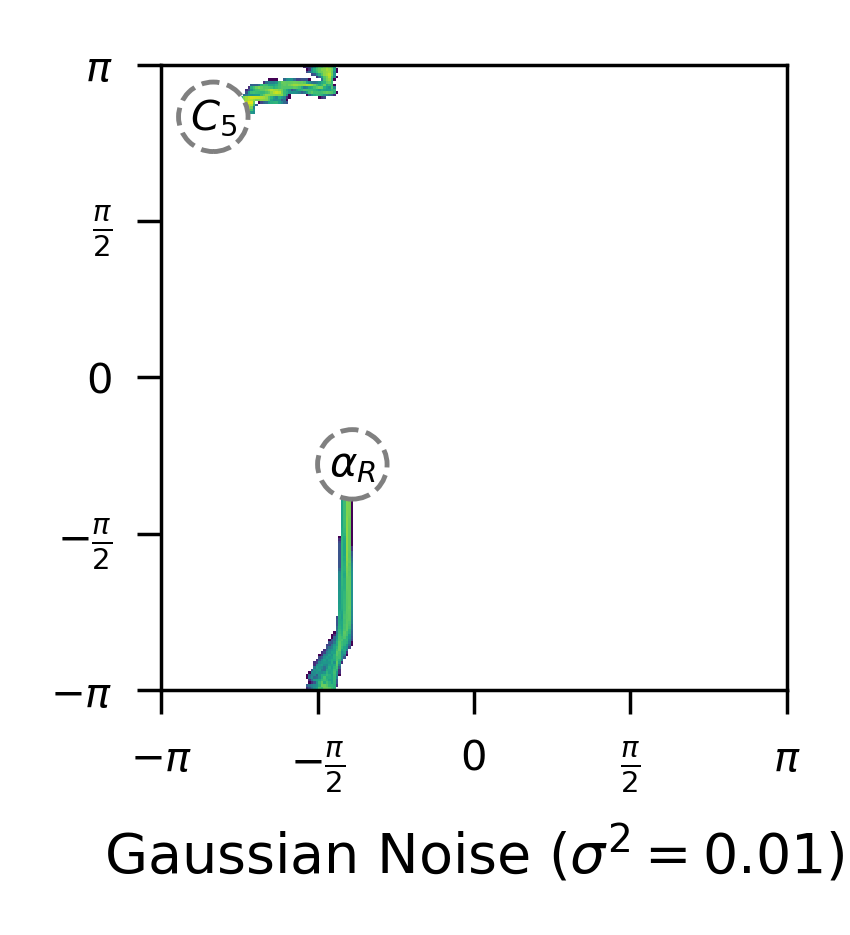

/data/rsg/nlp/mplainer/gen/tps/evaluation/utils.py:72: RuntimeWarning:

divide by zero encountered in log

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 647.93it/s]
/tmp/ipykernel_367089/596255806.py:20: RuntimeWarning:

divide by zero encountered in log

/tmp/ipykernel_367089/596255806.py:20: RuntimeWarning:

invalid value encountered in subtract

/tmp/ipykernel_367089/596255806.py:20: RuntimeWarning:

invalid value encountered in multiply



Gaussian Noise ($\sigma^2=0.01$)  {'KL-NN': '6.36e+00', 'KL-PathHist': '-2.43e-03', 'PathHist-AbsDist': '3.00e-05'}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 545.36it/s]


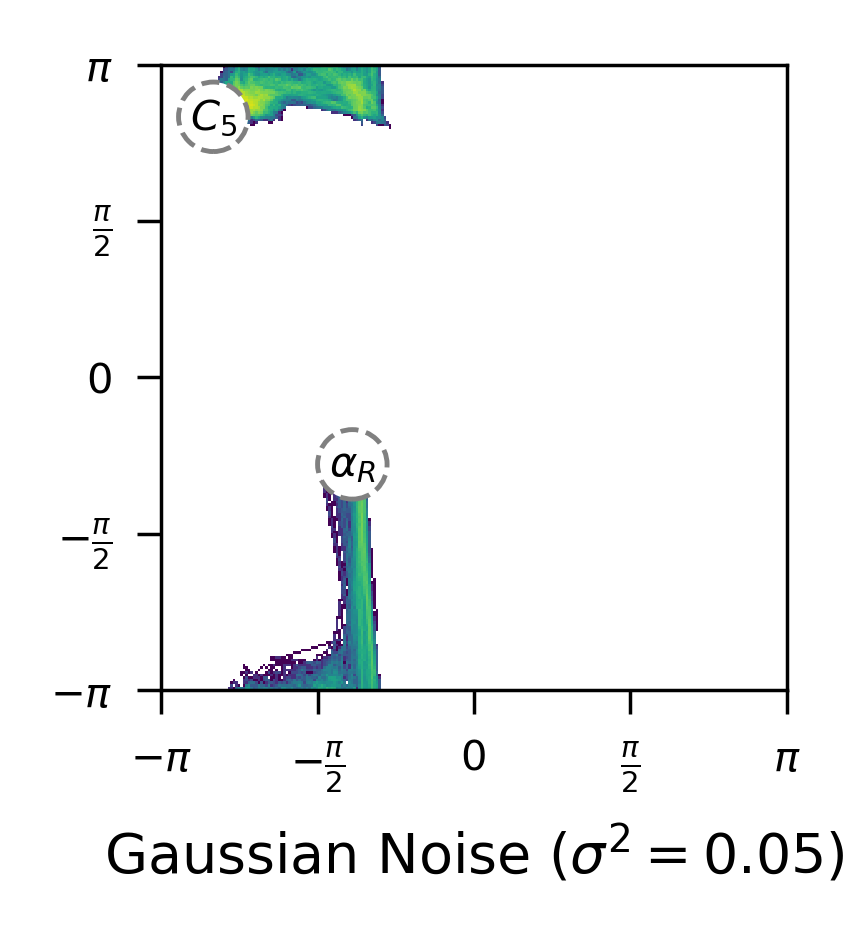

/data/rsg/nlp/mplainer/gen/tps/evaluation/utils.py:72: RuntimeWarning:

divide by zero encountered in log

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 554.55it/s]
/tmp/ipykernel_367089/596255806.py:20: RuntimeWarning:

divide by zero encountered in log

/tmp/ipykernel_367089/596255806.py:20: RuntimeWarning:

invalid value encountered in subtract

/tmp/ipykernel_367089/596255806.py:20: RuntimeWarning:

invalid value encountered in multiply



Gaussian Noise ($\sigma^2=0.05$)  {'KL-NN': '5.12e+00', 'KL-PathHist': '-2.28e-04', 'PathHist-AbsDist': '2.76e-05'}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 547.80it/s]


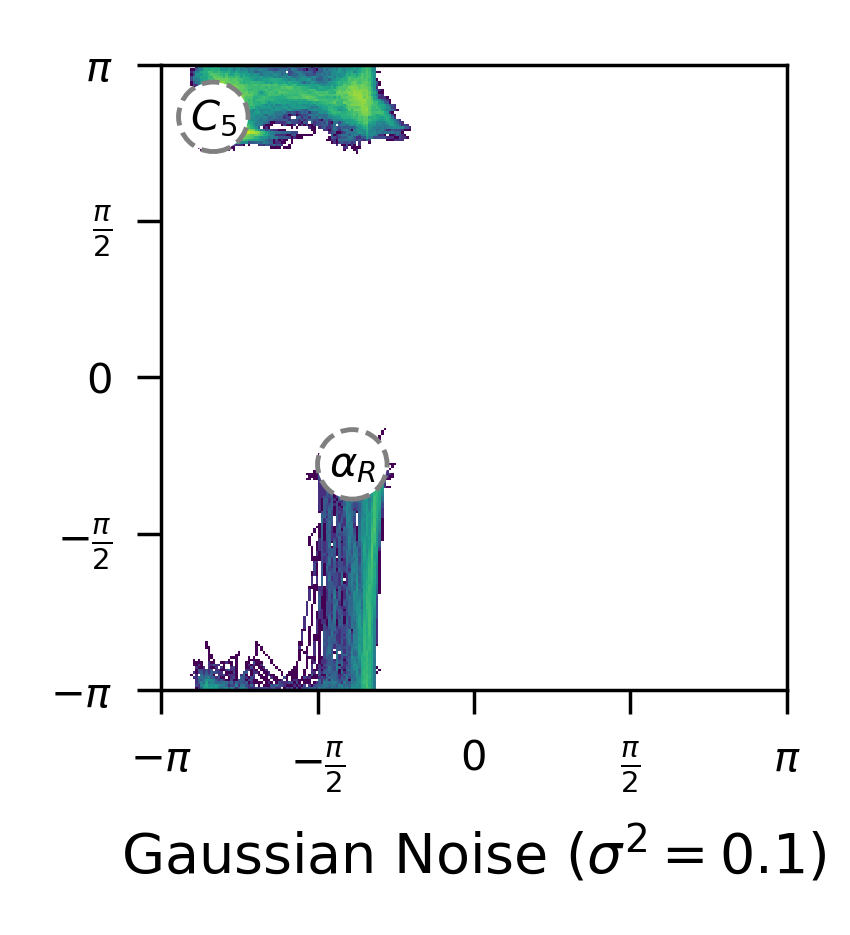

/data/rsg/nlp/mplainer/gen/tps/evaluation/utils.py:72: RuntimeWarning:

divide by zero encountered in log

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 556.15it/s]

Gaussian Noise ($\sigma^2=0.1$)  {'KL-NN': '4.11e+00', 'KL-PathHist': '1.99e-03', 'PathHist-AbsDist': '2.53e-05'}



/tmp/ipykernel_367089/596255806.py:20: RuntimeWarning:

divide by zero encountered in log

/tmp/ipykernel_367089/596255806.py:20: RuntimeWarning:

invalid value encountered in subtract

/tmp/ipykernel_367089/596255806.py:20: RuntimeWarning:

invalid value encountered in multiply



<Figure size 1250x812.5 with 0 Axes>

In [114]:
noise_level_figures = [
    ('Gaussian Noise ($\sigma^2=0.01$)', 'latent-noise-0.01', 'mcmc_prob_langevin_40_noise0.01_seed0'),
    ('Gaussian Noise ($\sigma^2=0.05$)', 'latent-noise-0.05', 'mcmc_prob_langevin_40_noise0.05_seed0'),
    ('Gaussian Noise ($\sigma^2=0.1$)', 'latent-noise-0.1', 'mcmc_prob_langevin_40_noise0.1_seed0'),
]

process_figures(noise_level_figures, no_ticks=False)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 561.48it/s]


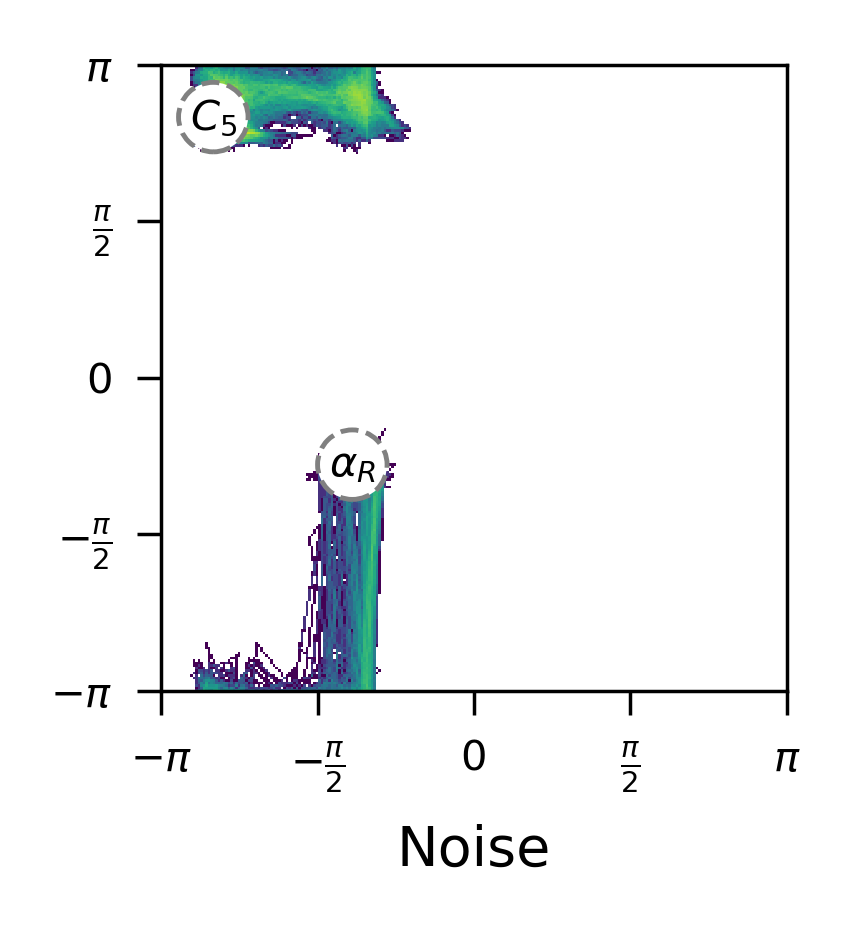

/data/rsg/nlp/mplainer/gen/tps/evaluation/utils.py:72: RuntimeWarning:

divide by zero encountered in log

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 520.56it/s]
/tmp/ipykernel_367089/596255806.py:20: RuntimeWarning:

divide by zero encountered in log

/tmp/ipykernel_367089/596255806.py:20: RuntimeWarning:

invalid value encountered in subtract

/tmp/ipykernel_367089/596255806.py:20: RuntimeWarning:

invalid value encountered in multiply



Noise  {'KL-NN': '4.11e+00', 'KL-PathHist': '1.99e-03', 'PathHist-AbsDist': '2.53e-05'}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 419.38it/s]


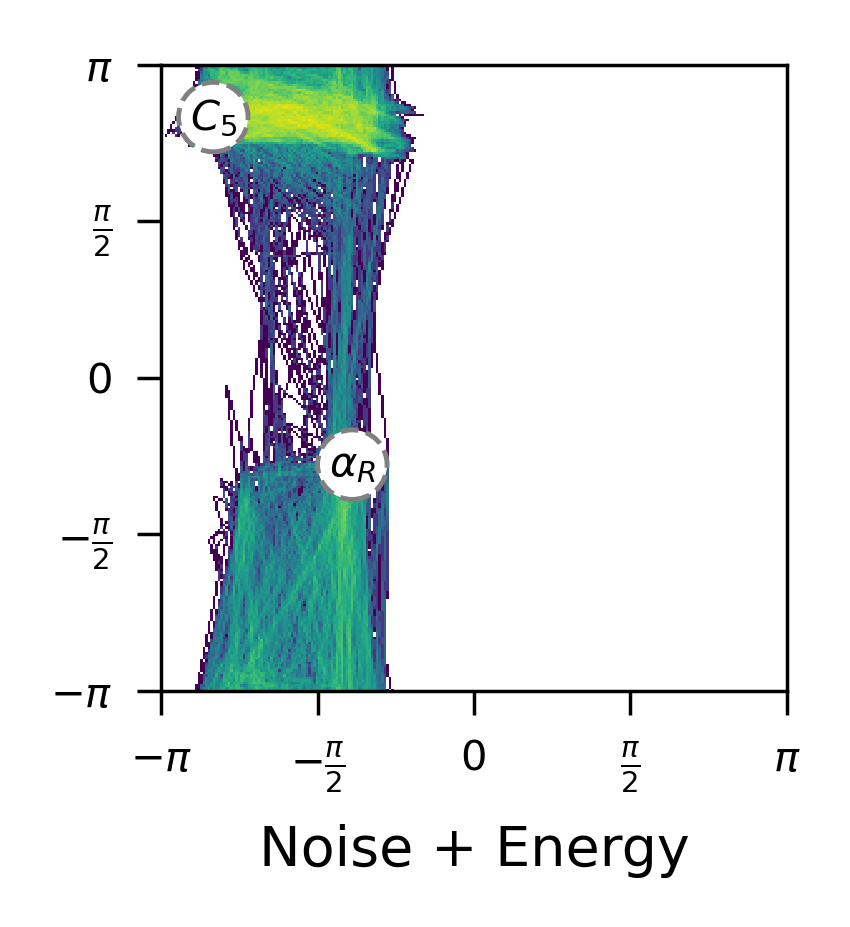

/data/rsg/nlp/mplainer/gen/tps/evaluation/utils.py:72: RuntimeWarning:

divide by zero encountered in log

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 418.53it/s]
/tmp/ipykernel_367089/596255806.py:20: RuntimeWarning:

divide by zero encountered in log

/tmp/ipykernel_367089/596255806.py:20: RuntimeWarning:

invalid value encountered in subtract

/tmp/ipykernel_367089/596255806.py:20: RuntimeWarning:

invalid value encountered in multiply



Noise + Energy  {'KL-NN': '2.08e+00', 'KL-PathHist': '1.2e-02', 'PathHist-AbsDist': '1.94e-05'}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 473.68it/s]


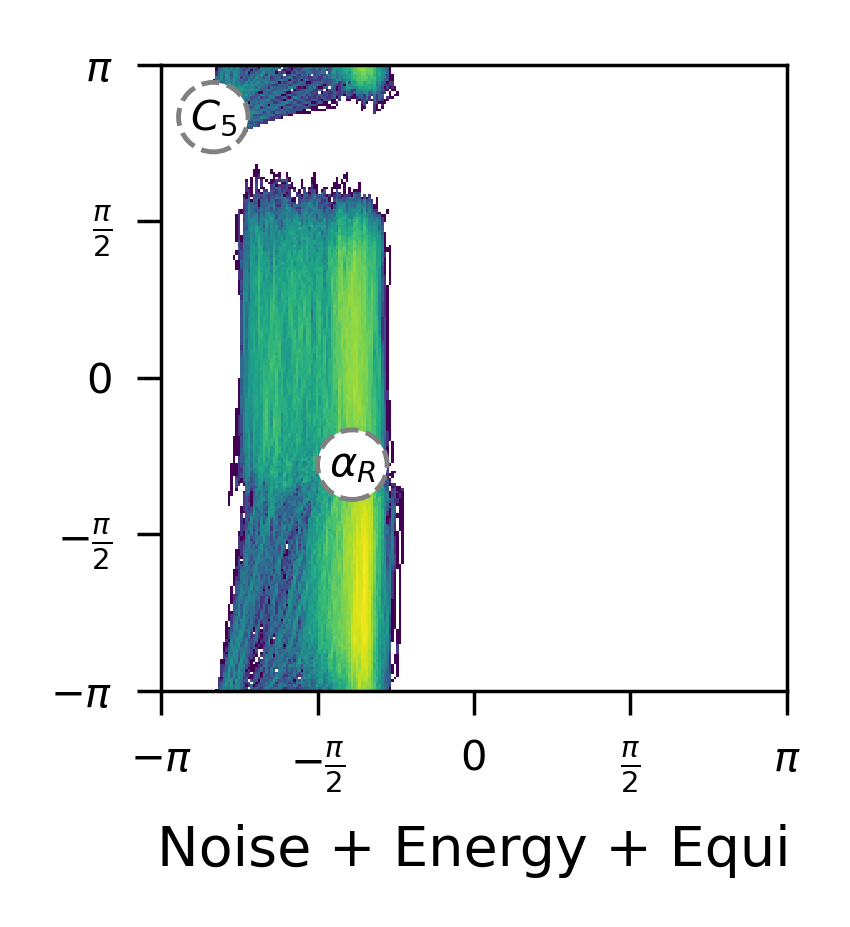

/data/rsg/nlp/mplainer/gen/tps/evaluation/utils.py:72: RuntimeWarning:

divide by zero encountered in log

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 471.73it/s]

Noise + Energy + Equi  {'KL-NN': '1.84e+00', 'KL-PathHist': '9.32e-03', 'PathHist-AbsDist': '1.85e-05'}



/tmp/ipykernel_367089/596255806.py:20: RuntimeWarning:

divide by zero encountered in log

/tmp/ipykernel_367089/596255806.py:20: RuntimeWarning:

invalid value encountered in subtract

/tmp/ipykernel_367089/596255806.py:20: RuntimeWarning:

invalid value encountered in multiply



<Figure size 1250x812.5 with 0 Axes>

In [116]:
approximation_figures = [
    ('Noise', 'latent-noise-langevin', 'mcmc_prob_langevin_40_noise0.1_seed0'),
    ('Noise + Energy', 'latent-noise-energy', 'mcmc_prob_energy_noise0.1_seed0'),
    ('Noise + Energy + Equi', 'latent-noise-energy-equidistant', 'mcmc_prob_energy_noise0.1_equi_10seed0'),
]

process_figures(approximation_figures, no_ticks=False)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 539.80it/s]


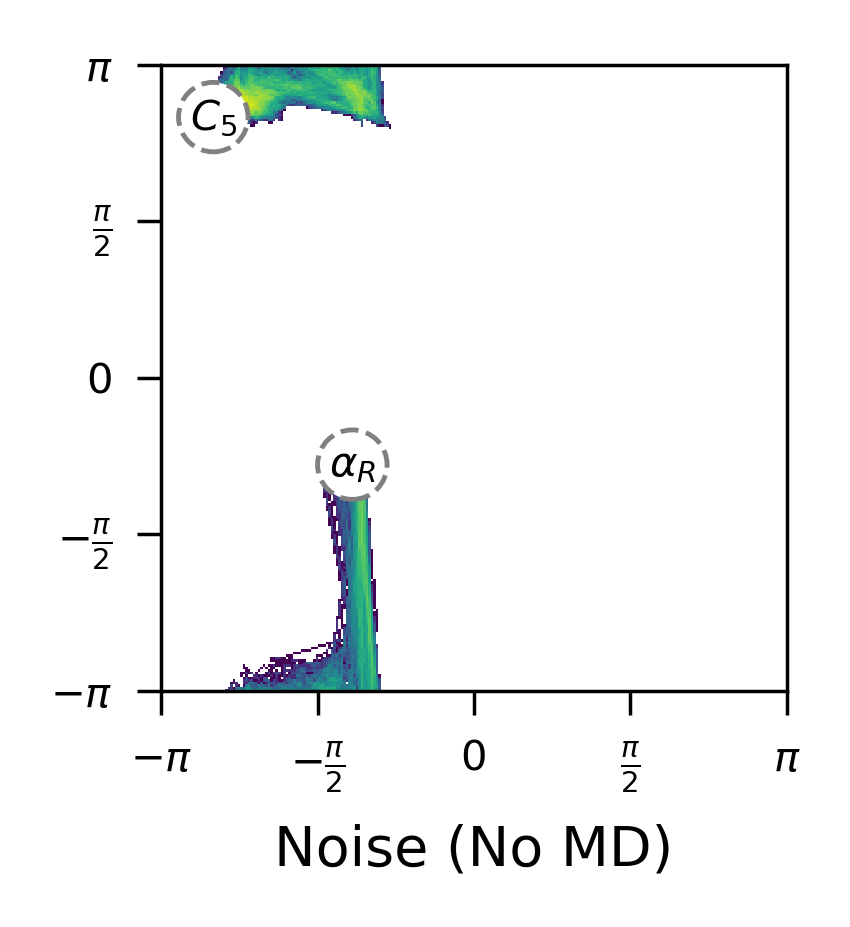

/data/rsg/nlp/mplainer/gen/tps/evaluation/utils.py:72: RuntimeWarning:

divide by zero encountered in log

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 549.24it/s]
/tmp/ipykernel_367089/596255806.py:20: RuntimeWarning:

divide by zero encountered in log

/tmp/ipykernel_367089/596255806.py:20: RuntimeWarning:

invalid value encountered in subtract

/tmp/ipykernel_367089/596255806.py:20: RuntimeWarning:

invalid value encountered in multiply



Noise (No MD)  {'KL-NN': '5.12e+00', 'KL-PathHist': '-2.28e-04', 'PathHist-AbsDist': '2.76e-05'}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 509.93it/s]


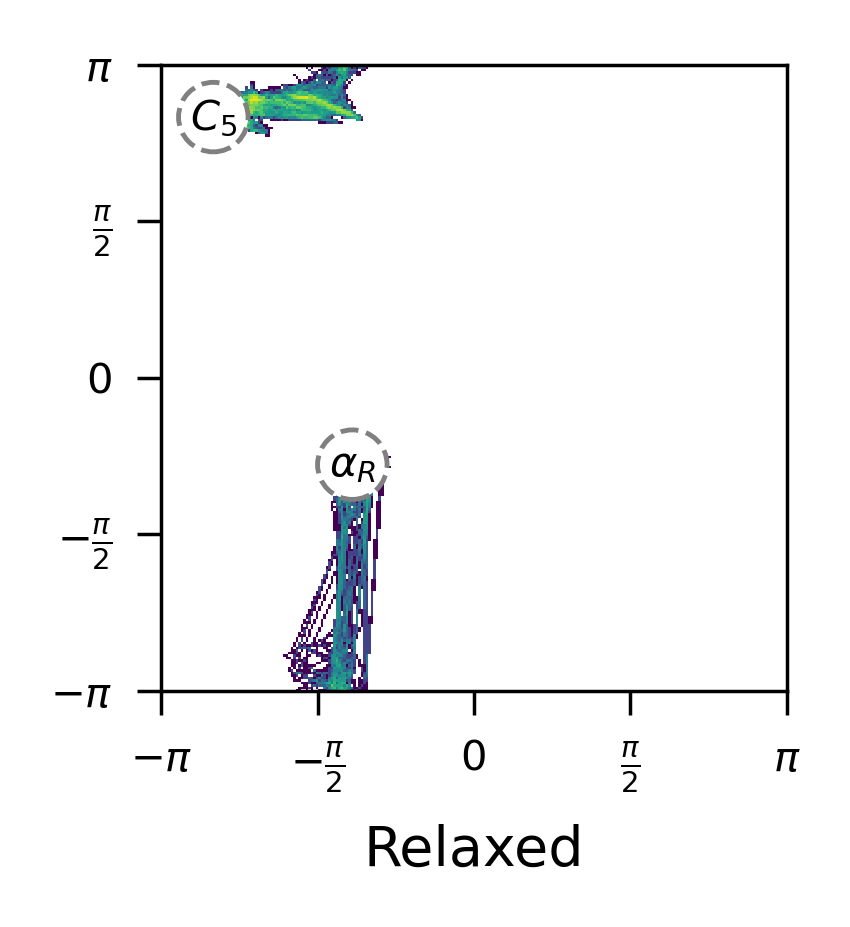

/data/rsg/nlp/mplainer/gen/tps/evaluation/utils.py:72: RuntimeWarning:

divide by zero encountered in log

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 627.51it/s]
/tmp/ipykernel_367089/596255806.py:20: RuntimeWarning:

divide by zero encountered in log

/tmp/ipykernel_367089/596255806.py:20: RuntimeWarning:

invalid value encountered in subtract

/tmp/ipykernel_367089/596255806.py:20: RuntimeWarning:

invalid value encountered in multiply



Relaxed  {'KL-NN': '4.16e+00', 'KL-PathHist': '-2.87e-03', 'PathHist-AbsDist': '2.77e-05'}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 348.38it/s]


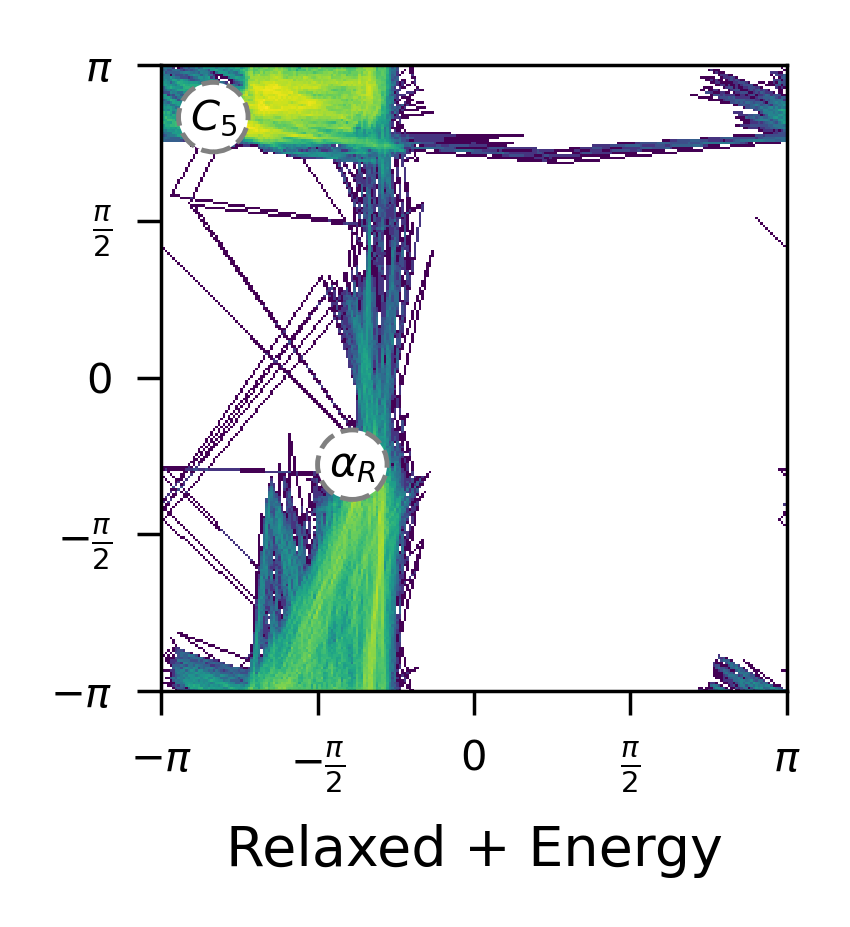

/data/rsg/nlp/mplainer/gen/tps/evaluation/utils.py:72: RuntimeWarning:

divide by zero encountered in log

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 355.08it/s]
/tmp/ipykernel_367089/596255806.py:20: RuntimeWarning:

divide by zero encountered in log

/tmp/ipykernel_367089/596255806.py:20: RuntimeWarning:

invalid value encountered in subtract

/tmp/ipykernel_367089/596255806.py:20: RuntimeWarning:

invalid value encountered in multiply



Relaxed + Energy  {'KL-NN': '3.24e+00', 'KL-PathHist': '1.08e-02', 'PathHist-AbsDist': '2.29e-05'}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 319.78it/s]


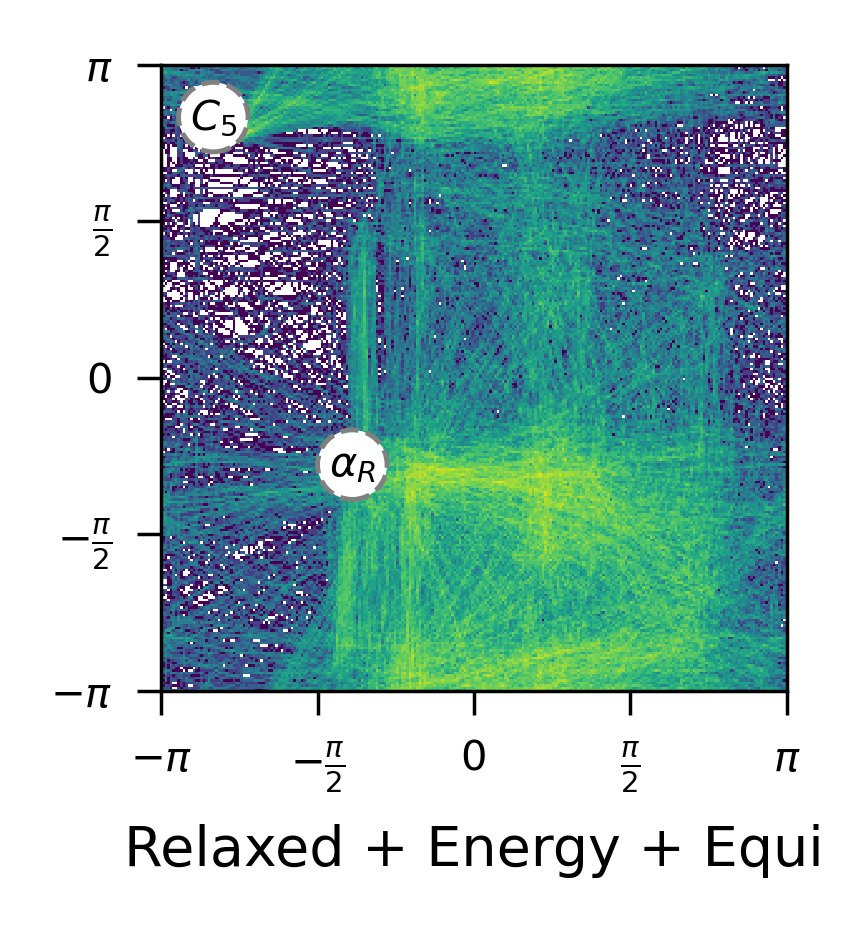

/data/rsg/nlp/mplainer/gen/tps/evaluation/utils.py:72: RuntimeWarning:

divide by zero encountered in log

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 335.06it/s]

Relaxed + Energy + Equi  {'KL-NN': '2.65e+00', 'KL-PathHist': '4.93e-02', 'PathHist-AbsDist': '2.64e-05'}



/tmp/ipykernel_367089/596255806.py:20: RuntimeWarning:

divide by zero encountered in log

/tmp/ipykernel_367089/596255806.py:20: RuntimeWarning:

invalid value encountered in subtract

/tmp/ipykernel_367089/596255806.py:20: RuntimeWarning:

invalid value encountered in multiply



<Figure size 1250x812.5 with 0 Axes>

In [118]:
relaxed_figures = [
    ('Noise (No MD)', 'latent-noise-langevin-no-md', 'mcmc_prob_langevin_40_noise0.05_seed0'),
    ('Relaxed', 'relaxed-latent-noise-langevin', 'mcmc_relaxed_prob_langevin_40_noise0.05_seed0'),
    ('Relaxed + Energy', 'relaxed-latent-noise-energy', 'mcmc_relaxed_prob_energy_noise0.05_seed0'),
    ('Relaxed + Energy + Equi', 'relaxed-latent-noise-energy-equidistant', 'mcmc_relaxed_prob_energy_noise0.05_equi_10seed0'),
]

process_figures(relaxed_figures, no_ticks=False)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 325/325 [00:00<00:00, 563.91it/s]


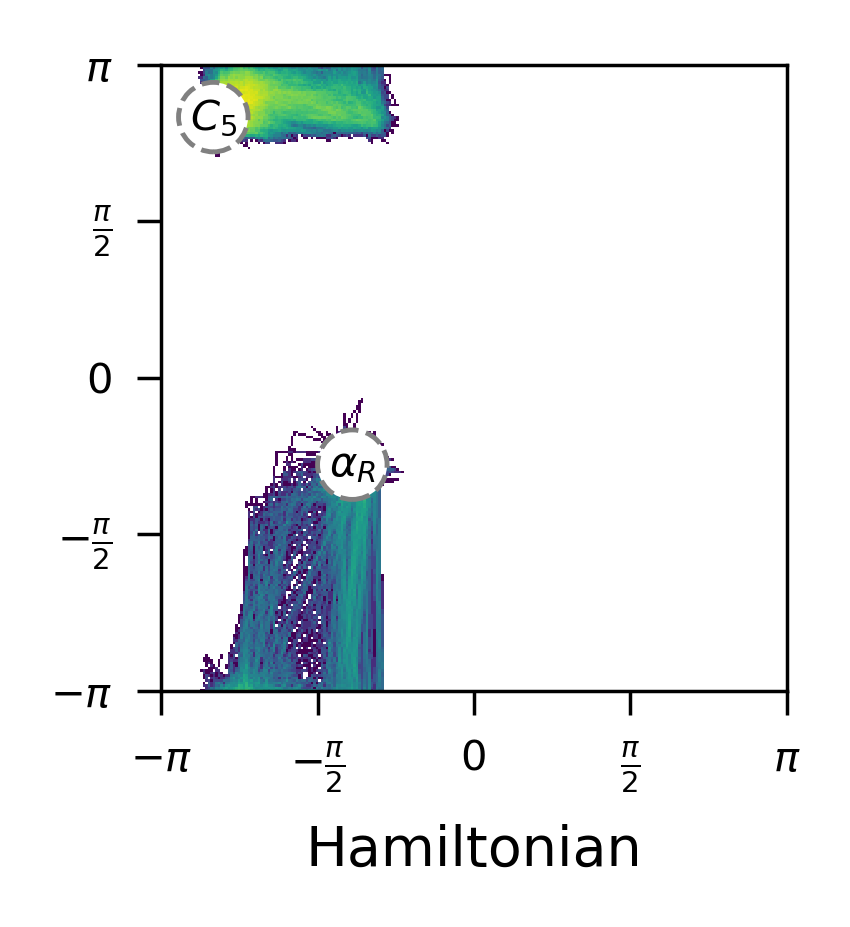

/data/rsg/nlp/mplainer/gen/tps/evaluation/utils.py:72: RuntimeWarning:

divide by zero encountered in log

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 325/325 [00:00<00:00, 555.33it/s]
/tmp/ipykernel_367089/3473181632.py:20: RuntimeWarning:

divide by zero encountered in log

/tmp/ipykernel_367089/3473181632.py:20: RuntimeWarning:

invalid value encountered in subtract

/tmp/ipykernel_367089/3473181632.py:20: RuntimeWarning:

invalid value encountered in multiply



Hamiltonian  {'KL-NN': '3.58e+00', 'KL-PathHist': '5.75e-03', 'PathHist-AbsDist': '2.35e-05'}


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 3429.30it/s]


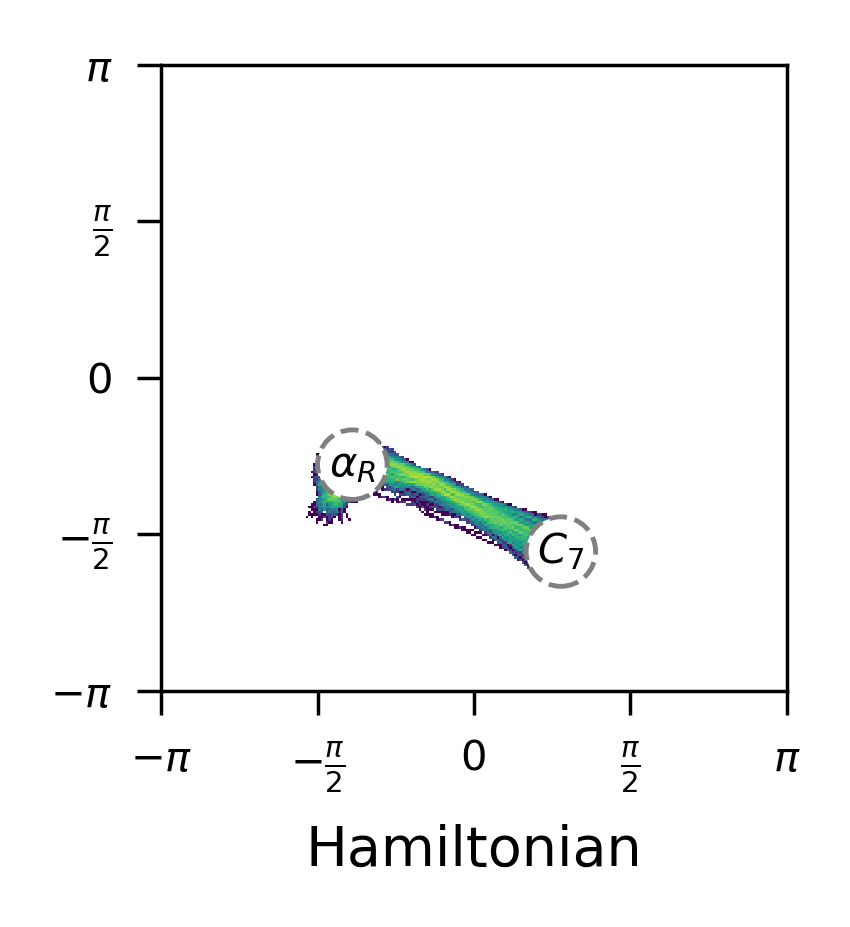

/data/rsg/nlp/mplainer/gen/tps/evaluation/utils.py:72: RuntimeWarning:

divide by zero encountered in log

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 3471.70it/s]

Hamiltonian hard {'KL-NN': '4.89e+00', 'KL-PathHist': '-2.56e-03', 'PathHist-AbsDist': '2.67e-05'}



/tmp/ipykernel_367089/3473181632.py:20: RuntimeWarning:

divide by zero encountered in log

/tmp/ipykernel_367089/3473181632.py:20: RuntimeWarning:

invalid value encountered in subtract

/tmp/ipykernel_367089/3473181632.py:20: RuntimeWarning:

invalid value encountered in multiply



<Figure size 1250x812.5 with 0 Axes>

In [120]:
hamiltonian_figures = [
    ('Hamiltonian', 'hamiltonian-ticks', 'mcmc_prob_langevin_hamiltonian500_10_0.01'),
    ('Hamiltonian', 'hamiltonian-ticks-hard-modes', '34mcmc_prob_langevin_hamiltonian_10_0.005_fixed'),
]

process_figures(hamiltonian_figures, no_ticks=False)

In [33]:
fixed_length_shooting = np.load("tps_simulations/ad_tps_fixed_length_A_D_path_hist.npz")['paths']
fixed_length_shooting.shape

(2330, 40, 2)

In [57]:
gaussian = np.array([np.stack(dataset.phis_psis(p)).T for p in load_paths('mcmc_prob_langevin_40_noise0.1')])
hamiltonian = np.array([np.stack(dataset.phis_psis(p)).T for p in load_paths('mcmc_prob_langevin_hamiltonian500_10_0.01')])

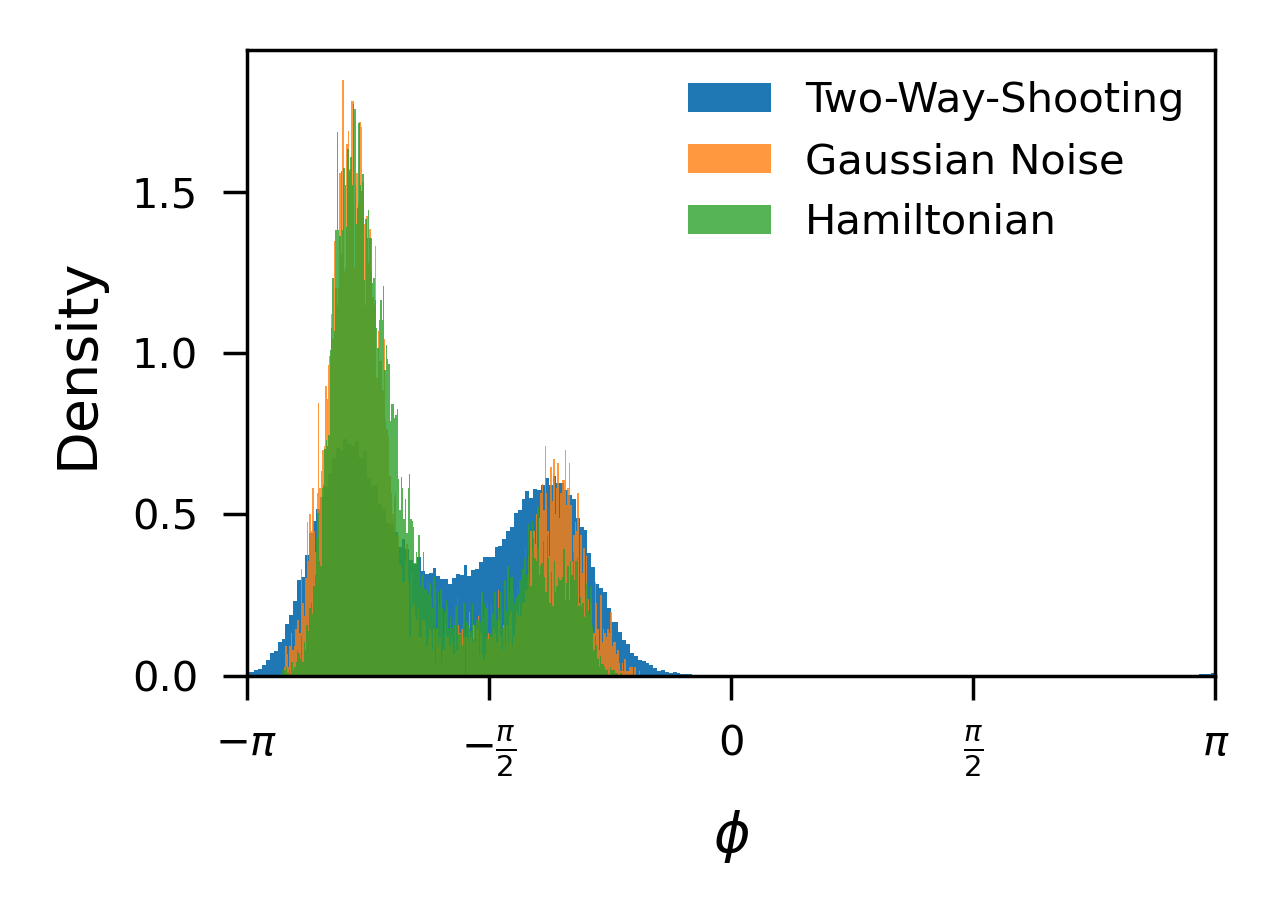

In [72]:
plt.hist(fixed_length_shooting[:, :, 0].flatten(), bins=250, label="Two-Way-Shooting", density=True, histtype='stepfilled')
plt.hist(gaussian[:, :, 0].flatten(), bins=250, label="Gaussian Noise", density=True, alpha=0.8, histtype='stepfilled')
plt.hist(hamiltonian[:, :, 0].flatten(), bins=250, label="Hamiltonian", density=True, alpha=0.8, histtype='stepfilled')
plt.xlabel(r"$\phi$")
plt.ylabel('Density')
plt.gca().set_xticks([-np.pi, -np.pi / 2, 0, np.pi / 2, np.pi])
plt.gca().set_xticklabels([r'$-\pi$', r'$-\frac {\pi} {2}$', '0', r'$\frac {\pi} {2}$', r'$\pi$'])
plt.legend()
plt.xlim(-np.pi, np.pi)
plt.savefig(f'figures/marginal-density-phi.pdf', bbox_inches='tight')

plt.show()

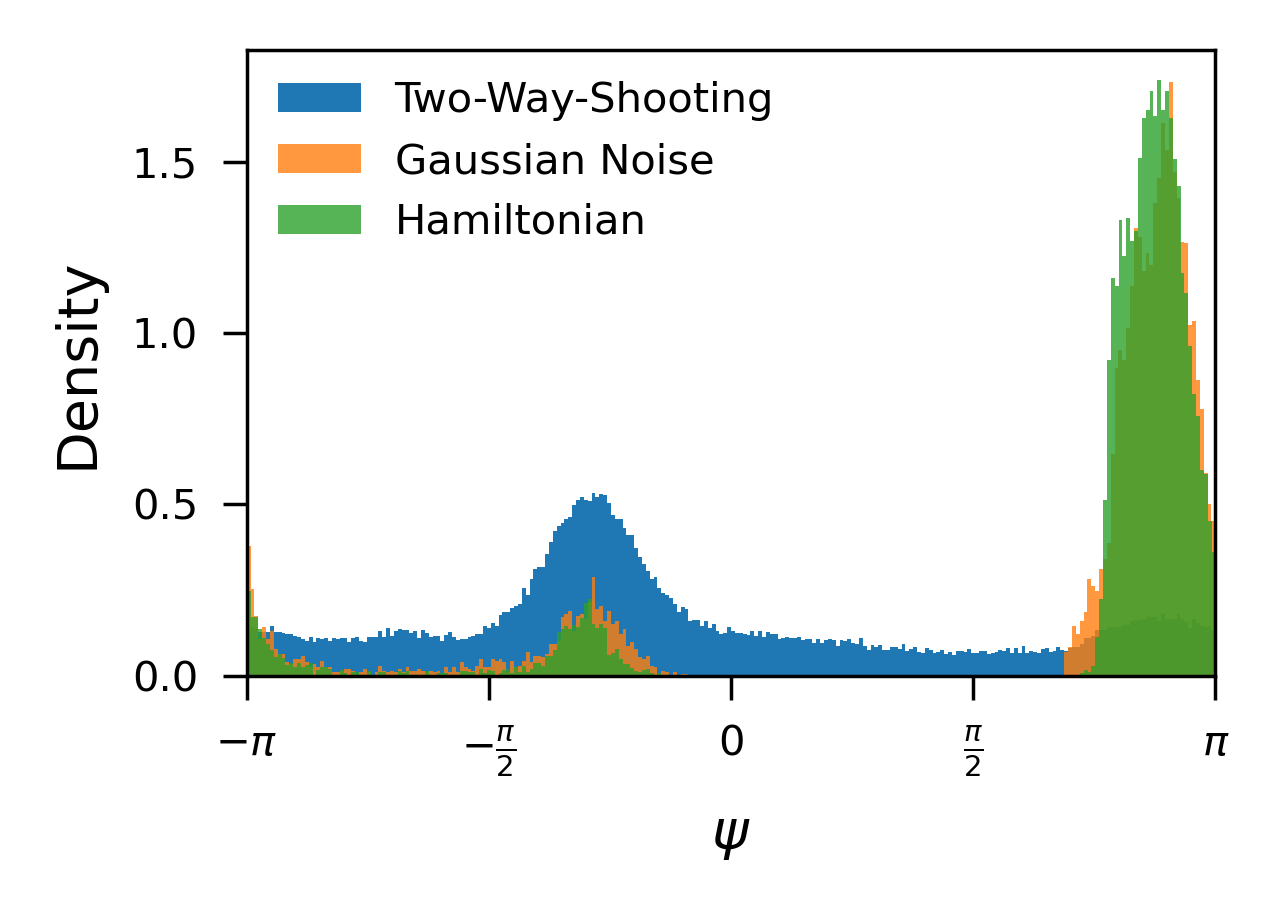

In [73]:
plt.hist(fixed_length_shooting[:, :, 1].flatten(), bins=250, label="Two-Way-Shooting", density=True, histtype='stepfilled')
plt.hist(gaussian[:, :, 1].flatten(), bins=250, label="Gaussian Noise", density=True, alpha=0.8, histtype='stepfilled')
plt.hist(hamiltonian[:, :, 1].flatten(), bins=250, label="Hamiltonian", density=True, alpha=0.8, histtype='stepfilled')
plt.xlabel(r"$\psi$")
plt.ylabel('Density')
plt.gca().set_xticks([-np.pi, -np.pi / 2, 0, np.pi / 2, np.pi])
plt.gca().set_xticklabels([r'$-\pi$', r'$-\frac {\pi} {2}$', '0', r'$\frac {\pi} {2}$', r'$\pi$'])
plt.legend()
plt.xlim(-np.pi, np.pi)
plt.savefig(f'figures/marginal-density-psi.pdf', bbox_inches='tight')

plt.show()

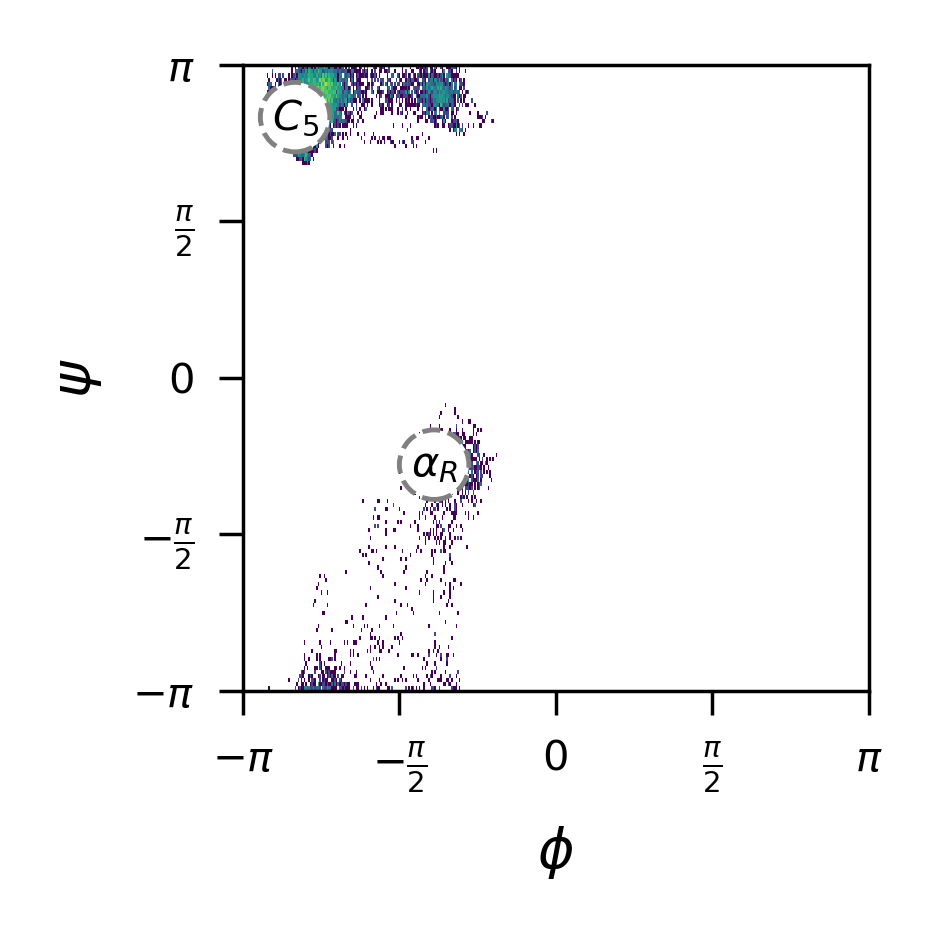

In [31]:
tmp = np.array(dataset.phis_psis(np.concatenate([path.detach().cpu().numpy() for path in tmp_paths]))).T
ramachandran_paper(tmp[:, 0], tmp[:, 1], [ALDP_STATES_NAMED[0], ALDP_STATES_NAMED[3]], alpha=1, bins=150)
plt.savefig('figures/ramachandran-aldp-latent-noise-hist.pdf', bbox_inches='tight')

array([-2.559607 ,  2.9081805], dtype=float32)

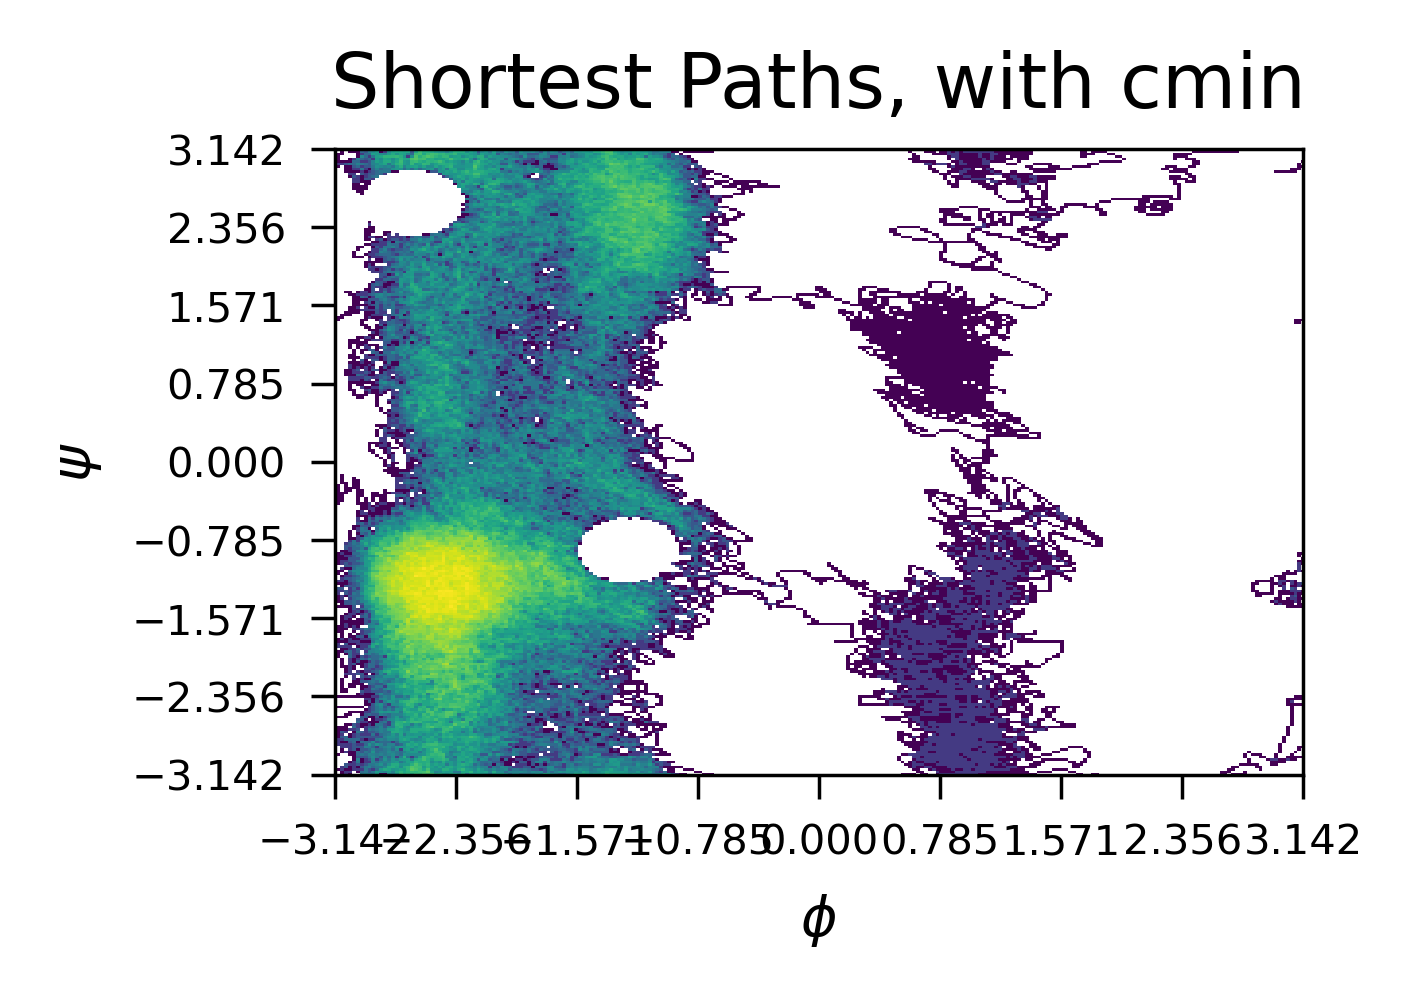

In [23]:
plt.title('Shortest Paths, with cmin')
path_hist.plot(norm=colors.LogNorm(), cmin=0)

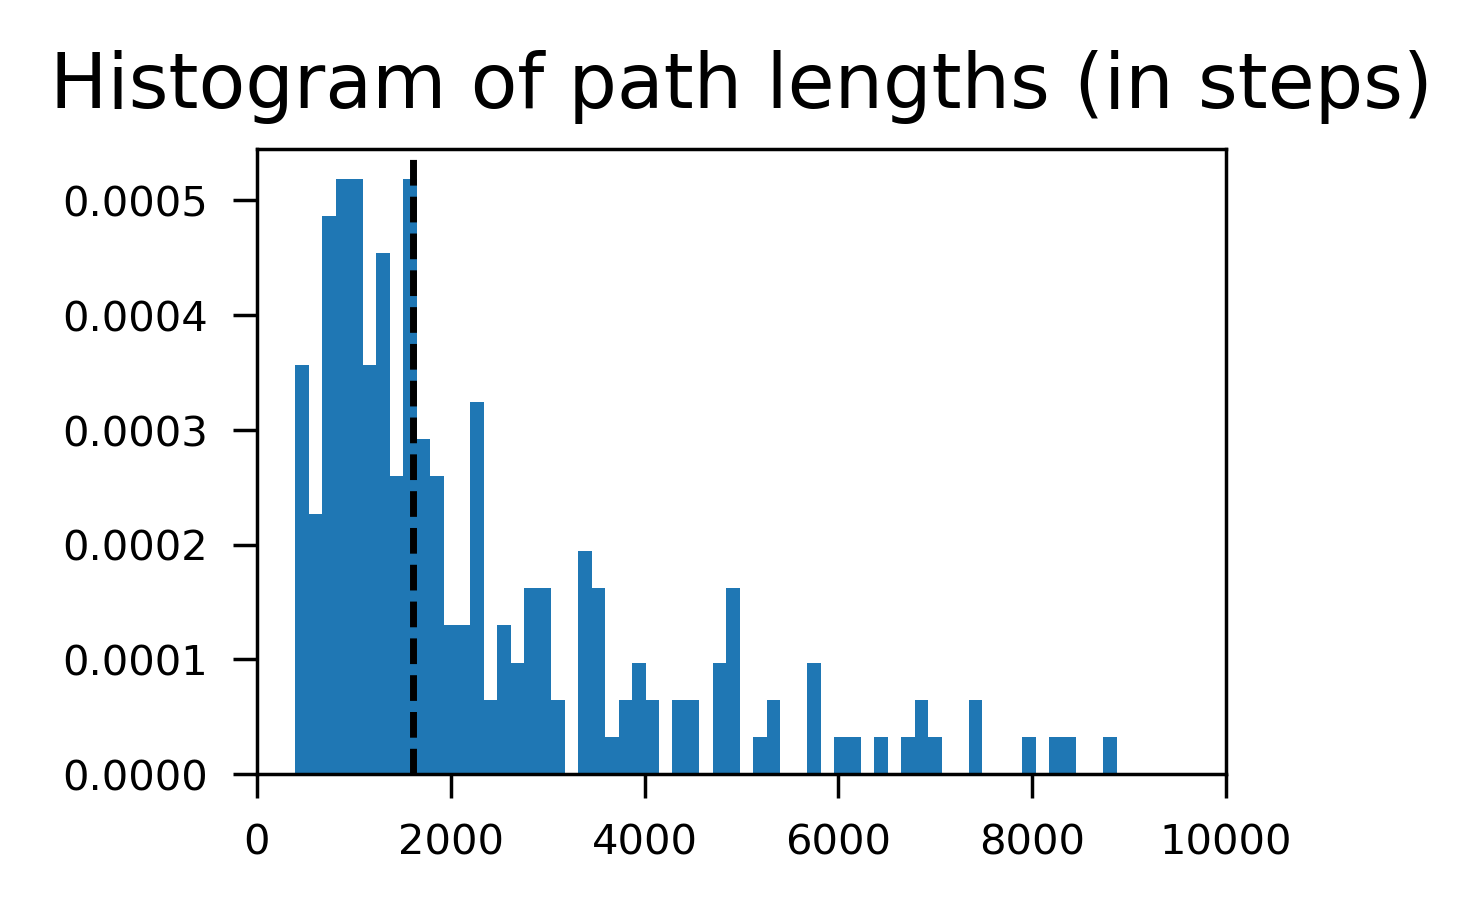

In [72]:
import matplotlib.pyplot as plt

path_lens = np.array(list(map(len, paths)))
plt.title('Histogram of path lengths (in steps)')
plt.hist(path_lens, bins=200, density=True)
plt.axvline(np.median(path_lens), color='k', linestyle='dashed', linewidth=1)
plt.xlim(0, 10000)
plt.show()

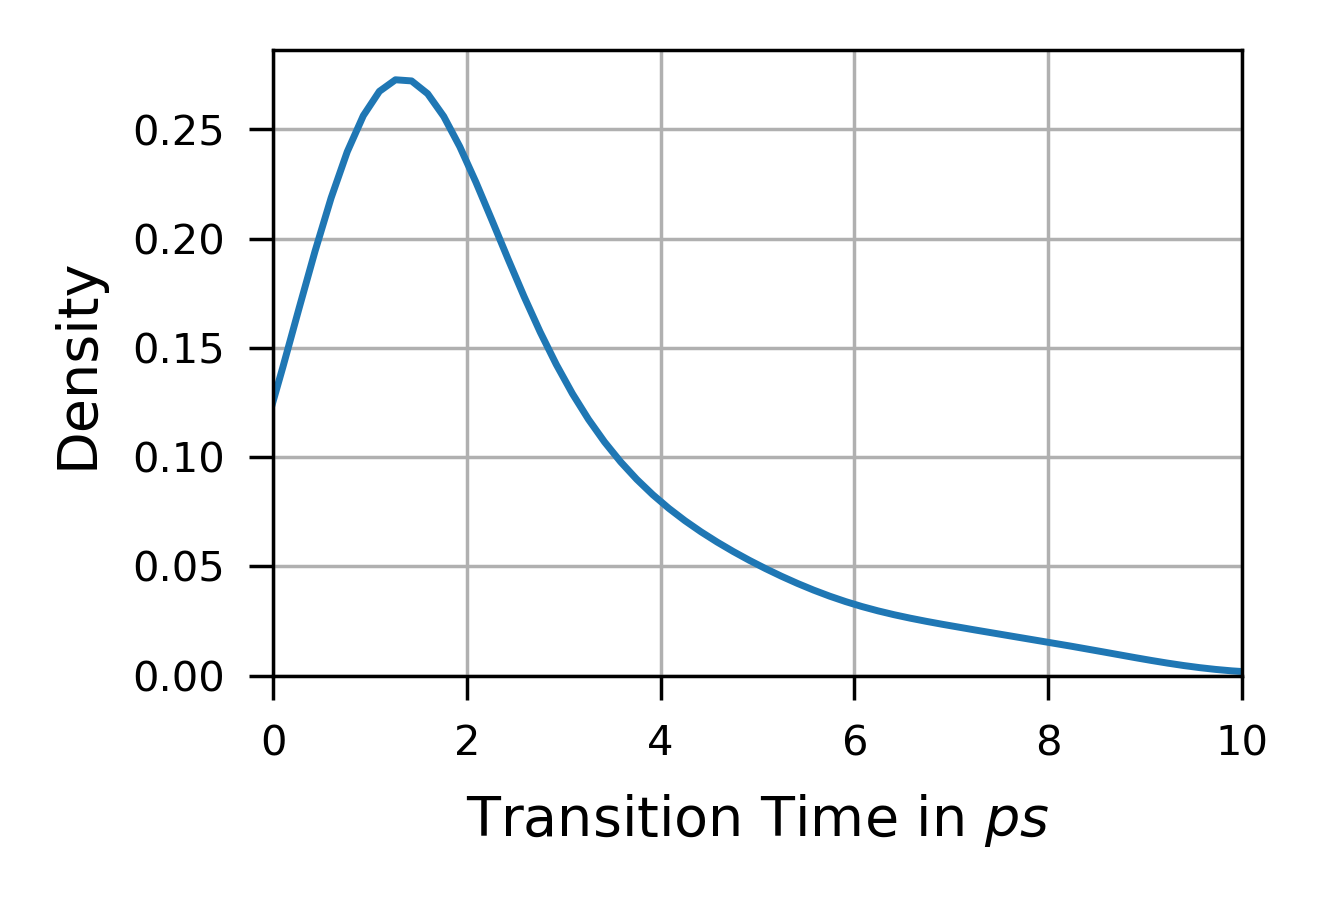

In [92]:
import seaborn as sns
sns.kdeplot(data=path_lens / 1000)
plt.xlim(0, 10)
plt.xlabel('Transition Time in $ps$')
plt.gca().grid()
plt.savefig('figures/aldp-transition-times.pdf', bbox_inches='tight')

array([ 6.935,  4.315,  1.24 ,  2.03 ,  1.099,  3.437,  1.536,  4.819,
        1.528,  3.032,  5.155, 28.193,  0.693,  1.114,  0.799,  0.78 ,
        0.978,  2.318,  0.941,  4.908,  1.629,  1.086,  0.908,  4.851,
        2.927,  2.271,  0.9  ,  0.702,  0.713,  2.792,  2.065,  1.683,
        1.129,  1.585,  1.5  ,  2.003,  0.984,  0.542,  3.371,  7.431,
        0.854,  1.617,  5.722,  0.858,  1.597, 11.887,  1.866,  3.488,
        1.293,  1.83 ,  0.623,  0.491,  1.563,  0.788,  1.354,  0.484,
        6.868,  1.837,  3.586,  0.862,  0.933,  4.975,  3.454,  6.486,
        1.163,  0.725,  0.733,  0.836,  4.384,  0.738,  1.732,  2.687,
        1.562,  1.874,  0.425,  1.258,  1.154,  8.267,  2.232,  6.085,
        3.706,  1.236,  4.063,  1.131,  2.035,  1.004,  6.804,  1.502,
        1.756,  2.491,  1.538,  2.23 ,  3.59 ,  0.525,  1.08 ,  0.712,
        0.397,  0.449,  2.28 ,  1.415,  1.652,  0.878,  2.688,  1.111,
        0.843,  1.167,  5.355,  4.041,  5.74 ,  2.596,  6.233,  4.476,
      

Threshold 6.0 Median 18.0 Mean 27.81084733714116


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 54904/54904 [00:11<00:00, 4592.73it/s]


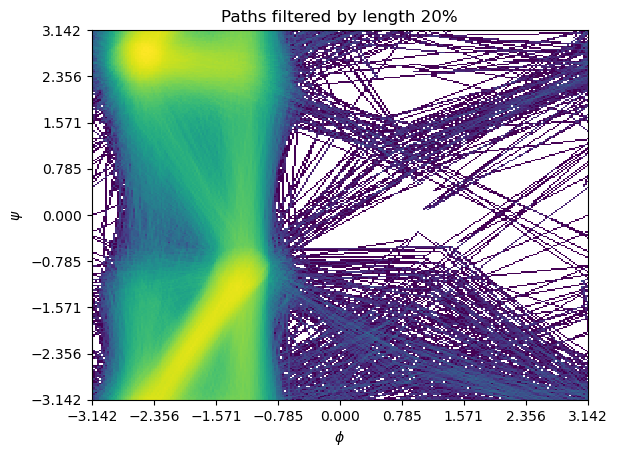

In [30]:
threshold = np.percentile(path_lens, 20)
print('Threshold', threshold, 'Median', np.median(path_lens), 'Mean', np.mean(path_lens))
paths_filtered = [p for p in paths if len(p) <= threshold]

paths_filtered_combined = np.concatenate(paths_filtered)
ramachandran_plot(paths_filtered_combined[:, 0], paths_filtered_combined[:, 1], ALDP_STATES, title='Ground Truth Ramachandran, len-based')

path_hist = PeriodicPathHistogram()
plt.title('Paths filtered by length 20%')
path_hist.add_paths(paths_filtered)
path_hist.plot(norm=colors.LogNorm())

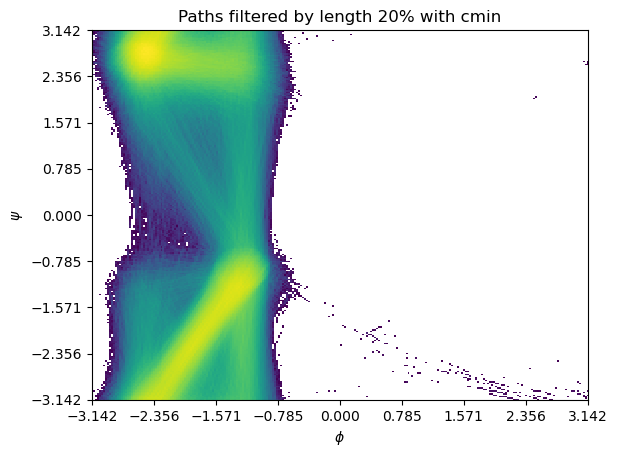

In [31]:
plt.title('Paths filtered by length 20% with cmin')
path_hist.plot(norm=colors.LogNorm(), cmin=10)

In [15]:
from tps.mcmc.density import EnergySumPathDensityEstimator, LangevinDensityEstimator
density = EnergySumPathDensityEstimator(dataset.target.log_prob_A)
paths_energy_sum = [density(p) for p in tqdm(paths_full)]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 241958/241958 [44:08<00:00, 91.36it/s]


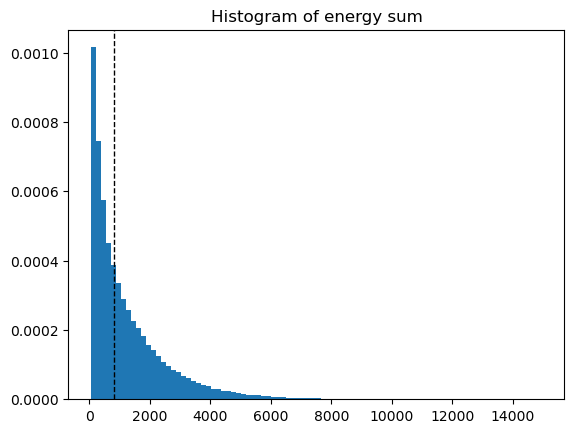

In [16]:
plt.hist(paths_energy_sum, bins=90, density=True)
plt.axvline(np.median(paths_energy_sum), color='k', linestyle='dashed', linewidth=1)
plt.title('Histogram of energy sum')
plt.show()

Threshold 264.8262451171875


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48392/48392 [00:19<00:00, 2489.10it/s]


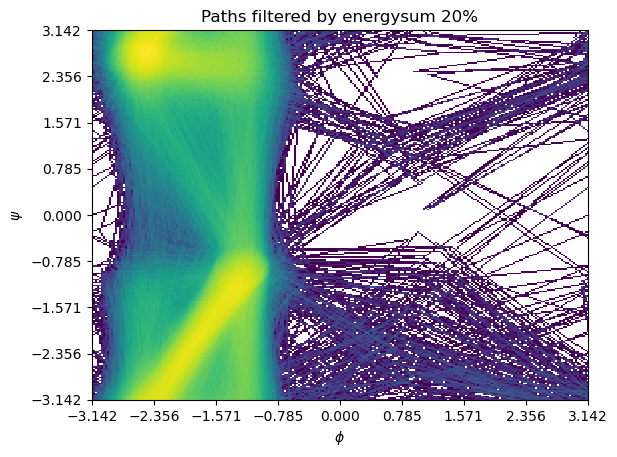

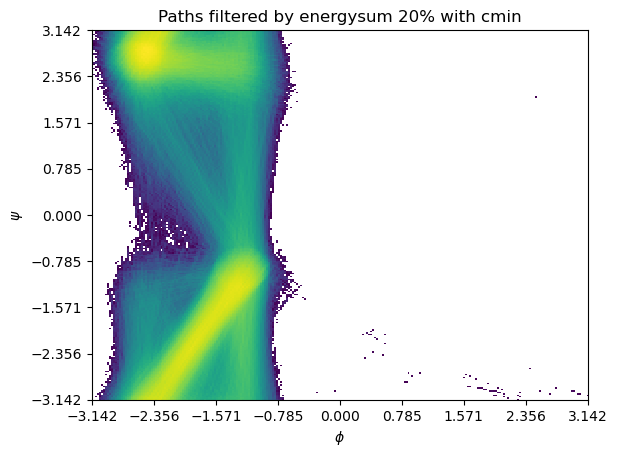

In [17]:
threshold = np.percentile(paths_energy_sum, 20)
print('Threshold', threshold)
paths_filtered_energy = [p for i, p in enumerate(paths) if paths_energy_sum[i] <= threshold]

path_hist = PeriodicPathHistogram()
path_hist.add_paths(paths_filtered_energy)
plt.title('Paths filtered by energysum 20%')
path_hist.plot(norm=colors.LogNorm())
plt.show()

plt.title('Paths filtered by energysum 20% with cmin')
path_hist.plot(norm=colors.LogNorm(), cmin=10)
plt.show()

paths_filtered_combined = np.concatenate(paths_filtered_energy)
ramachandran_plot(paths_filtered_combined[:, 0], paths_filtered_combined[:, 1], ALDP_STATES, bins=250, title='Ground Truth Ramachandran, energysum')

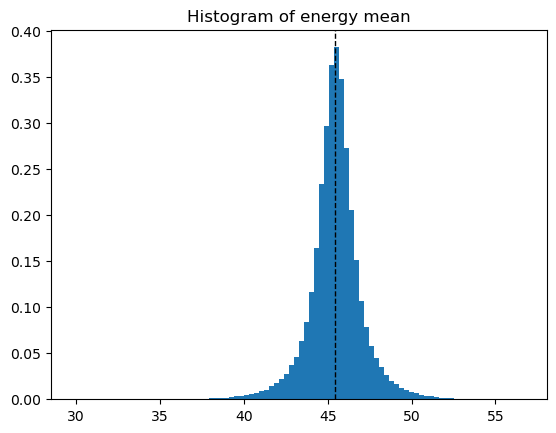

Threshold 42.922183418273924


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12099/12099 [00:08<00:00, 1433.41it/s]


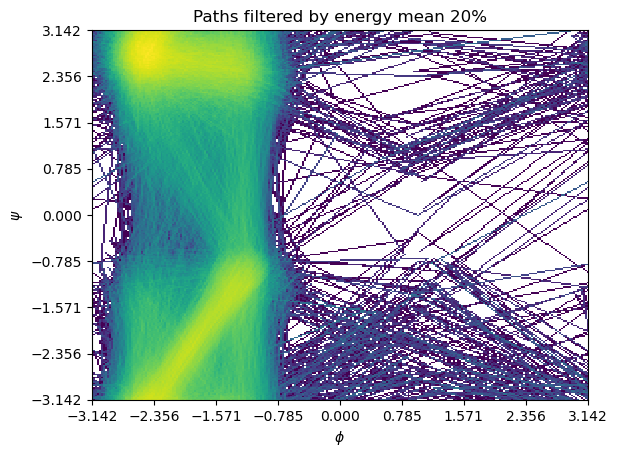

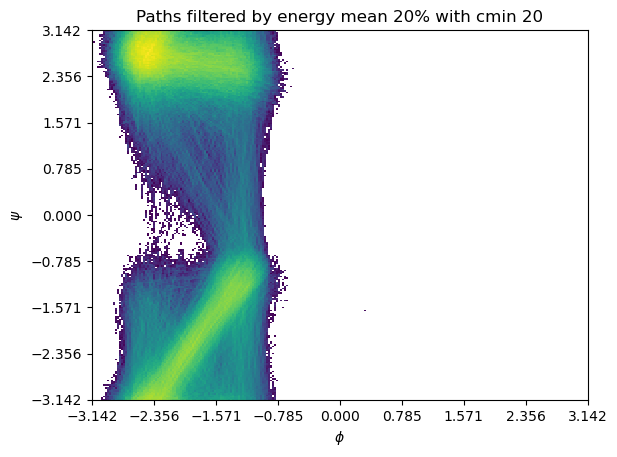

In [18]:
paths_energy_mean = torch.tensor(paths_energy_sum) / torch.tensor(path_lens)
plt.hist(paths_energy_mean, bins=90, density=True)
plt.axvline(np.median(paths_energy_mean), color='k', linestyle='dashed', linewidth=1)
plt.title('Histogram of energy mean')
plt.show()

threshold = np.percentile(paths_energy_mean, 5)
print('Threshold', threshold)
paths_filtered_mean_energy = [p for i, p in enumerate(paths) if paths_energy_mean[i] <= threshold]

path_hist = PeriodicPathHistogram()
path_hist.add_paths(paths_filtered_mean_energy)
plt.title('Paths filtered by energy mean 20%')
path_hist.plot(norm=colors.LogNorm())
plt.show()

plt.title('Paths filtered by energy mean 20% with cmin 20')
path_hist.plot(norm=colors.LogNorm(), cmin=20)
plt.show()

paths_filtered_combined = np.concatenate(paths_filtered_mean_energy)
ramachandran_plot(paths_filtered_combined[:, 0], paths_filtered_combined[:, 1], ALDP_STATES, bins=250, title='Ground Truth Ramachandran, energy mean')

In [27]:
from openmm import unit

density = LangevinDensityEstimator(dataset, independent_steps=False, step_size=args.data_save_frequency * unit.femtosecond)
paths_density = [density(p) for p in tqdm(paths_full)]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 241958/241958 [48:00<00:00, 83.99it/s]


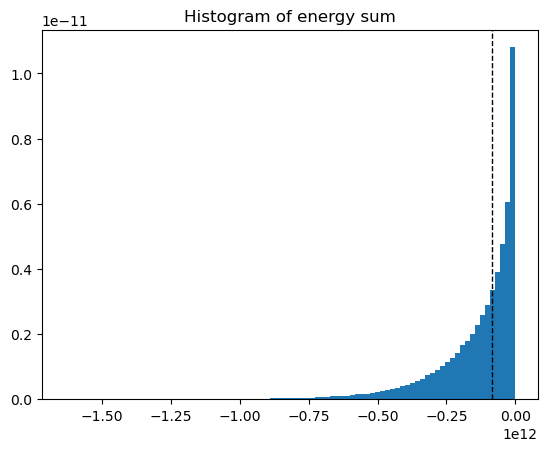

In [28]:
plt.hist(paths_density, bins=90, density=True)
plt.axvline(np.median(paths_density), color='k', linestyle='dashed', linewidth=1)
plt.title('Histogram of energy sum')
plt.show()

Threshold -225467857010.9549


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48392/48392 [03:39<00:00, 220.44it/s]


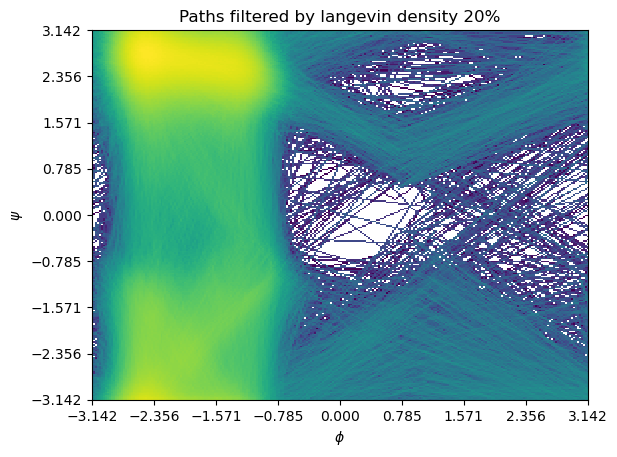

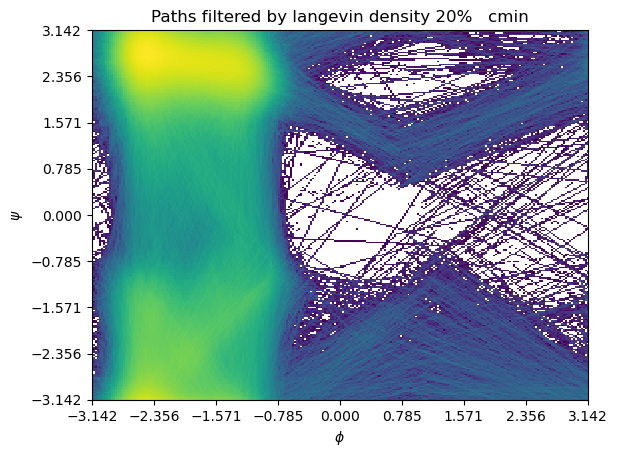

In [29]:
threshold = np.percentile(paths_density, 20)
print('Threshold', threshold)
paths_filtered_density = [p for i, p in enumerate(paths) if paths_density[i] <= threshold]

path_hist = PeriodicPathHistogram()
path_hist.add_paths(paths_filtered_density)
plt.title('Paths filtered by langevin density 20%')
path_hist.plot(norm=colors.LogNorm())
plt.show()

plt.title('Paths filtered by langevin density 20%   cmin')
path_hist.plot(norm=colors.LogNorm(), cmin=10)
plt.show()

paths_filtered_combined = np.concatenate(paths_filtered_energy)
ramachandran_plot(paths_filtered_combined[:, 0], paths_filtered_combined[:, 1], ALDP_STATES, bins=250, title='Ground Truth Ramachandran, density')